<h1> Exploring BERT embeddings </h1>

<h4> The aim is to get better understanding of BERT architecture and its hidden layers, using BERT with an MLM head for observation</h4>

##Contents




<h4> <li> Exploring the first embedding layer (Embedding table )</li>
<li> Last 4 layers summed up embeddings </li>
<li> Comparing the embeddings from the two different strategies </li>
<li> Sentence embeddings </li>
<li> Animated - how embedding values are changing as it passes through each of the 12 layers </li>

## Exploring the first embedding layer ( Embedding table )

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertConfig
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
import os, sys

In [ ]:
os.chdir("/content/transformers_deep_dive")

In [ ]:
sys.path.append("model")
sys.path.append("utils")
import extract_embeddings, graph

In [ ]:
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h4><li>Basic BERT architecture consists of multiple blocks</li>
<li>Each block has self-attention, fully-connected layer, dropout; there are 12 such blocks. </li>
<li>BERT has 2 pre-training tasks - MLM and NSP, where in MLM aim is to predict which word can best replace the [MASK] token</li>
<li> Output shape of hidden layers is [#layers, #samples in batch, #tokens, #dimensions] where #dimensions=768</li>
<li>Each word is decomposed into constituent tokens by tokenizer and for each token the corresponding embedding is read from embedding table. This along with position embedding and segment embedding serves as input to BERT</li>
<li>We will extract the embedding from the first layer for selected tokens and color-code the results to compare it visually</li>



['the', 'cat', 'is', 'asleep'] is tokenized as {'input_ids': tensor([[ 101, 1996, 4937, 2003, 6680,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[ 101, 1996, 4937, 2003, 6680,  102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1]])
[CLS] the cat is asleep [SEP]


['the', 'cat', 'is', 'awake'] is tokenized as {'input_ids': tensor([[ 101, 1996, 4937, 2003, 8300,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[ 101, 1996, 4937, 2003, 8300,  102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1]])
[CLS] the cat is awake [SEP]
min =  -2.366675
max =  1.6848819


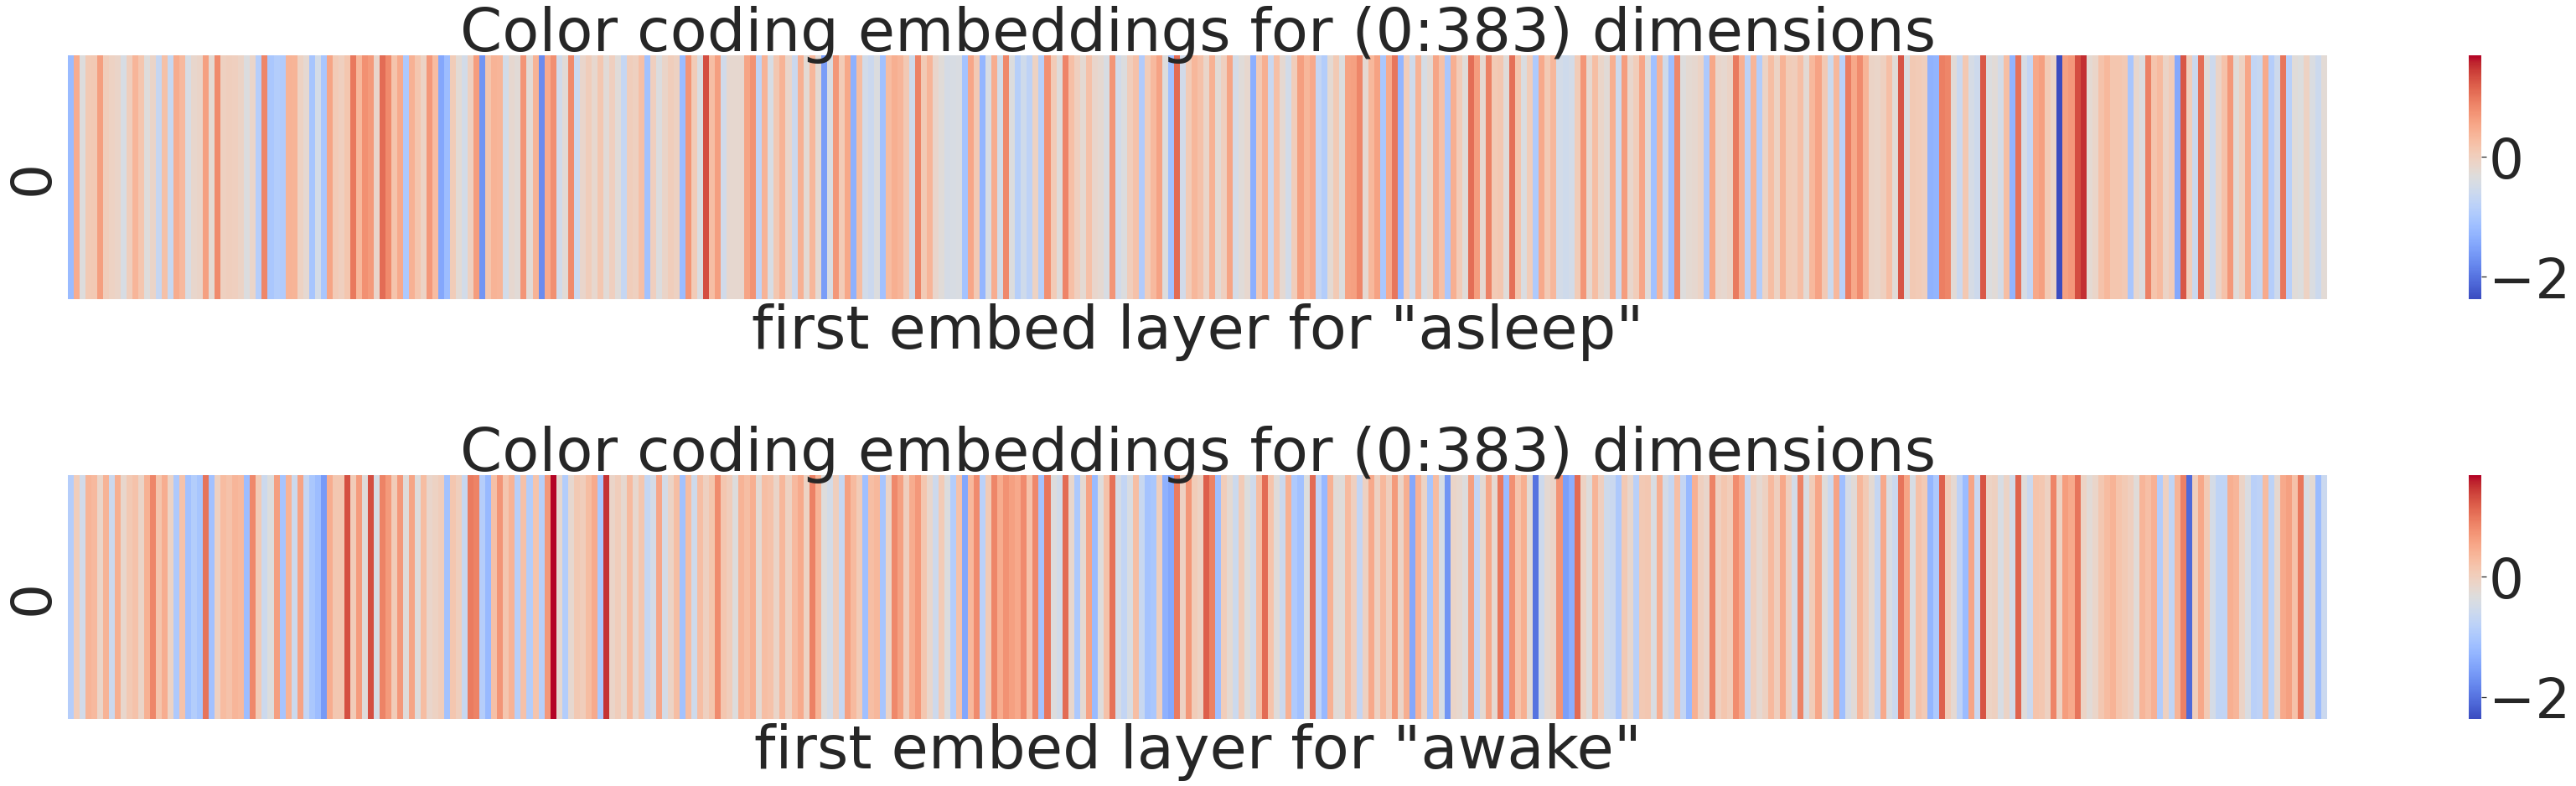

min =  -1.8476806
max =  1.8304615


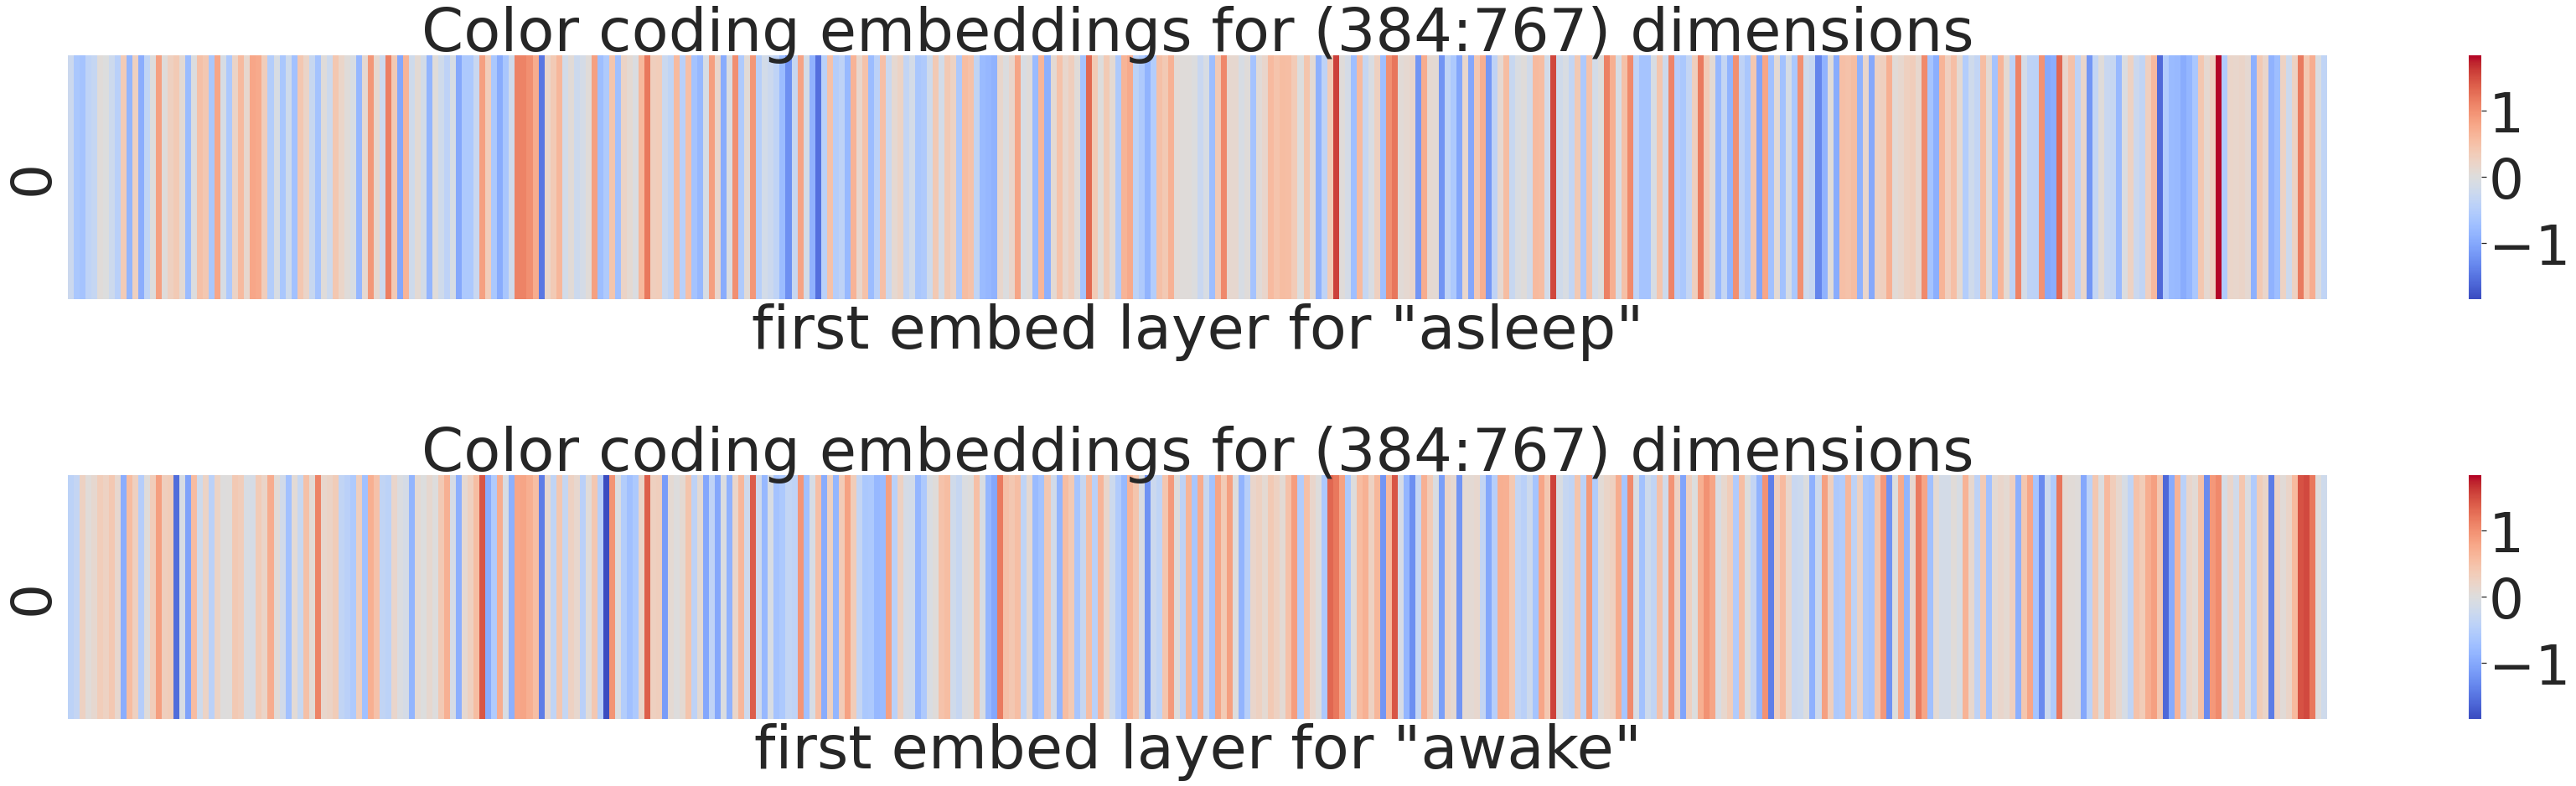

In [ ]:
#Input sentences
sentence_1 = ["the","cat","is","asleep"]
sentence_2 = ["the","cat","is","awake"]

s1_word_index = 3
s2_word_index = 3

args = {
    "model":model,
    "tokenized_input":extract_embeddings.get_tokenized_input(tokenizer,sentence_1),
    "hidden_state_index":0,
    "batch_index":0,
    "token_index":s1_word_index+1
}
s1_embed = extract_embeddings.get_token_embed(**args)

args["tokenized_input"] = extract_embeddings.get_tokenized_input(tokenizer,sentence_2)
args["token_index"] = s2_word_index+1
s2_embed = extract_embeddings.get_token_embed(**args)

fl_embeds = [s1_embed, s2_embed]
viz = {
    "embeddings":[x[0:384] for x in fl_embeds],
    "layer_display_names":["first embed layer"]*2,
    "words":[sentence_1[s1_word_index], sentence_2[s2_word_index]],
    "title":"Color coding embeddings for (0:383) dimensions",
    "save":False,
    "mode":"compare"
}
graph.plot_embeds(**viz)

viz["embeddings"] = [x[384:] for x in fl_embeds]
viz["title"] = "Color coding embeddings for (384:767) dimensions"
graph.plot_embeds(**viz)

<h4>
<li>For all sentences, I'm keeping batch size as 1 for clarity. From the output of tokenizer.decode we can see that none of the words are being decomposed into subwords so words and tokens for us is interchangeable although this won't be always be the case. So we can use word_index + 1 as corresponding token_index for that word.</li>
<li>We can see that the embeddings have similar values for the same dimensions - probably because "awake" and "asleep" are both verbs defining "sleep"</li>
<li>There are sharply contrasting colors for same dimension as well - in 384:767 near the far right we can see this - are these values the differentiating factor, using which BERT understands the difference between tokens ? </li>
<li>Let's take 2 words with totally different meanings and see the values for the hidden dimensions</li>
</h4>



['after', 'the', 'rain', 'a', 'beautiful', 'rainbow', 'spread', 'across', 'the', 'sky'] is tokenized as {'input_ids': tensor([[  101,  2044,  1996,  4542,  1037,  3376, 10098,  3659,  2408,  1996,
          3712,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[  101,  2044,  1996,  4542,  1037,  3376, 10098,  3659,  2408,  1996,
          3712,   102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
[CLS] after the rain a beautiful rainbow spread across the sky [SEP]
min =  -2.178121
max =  1.6898276


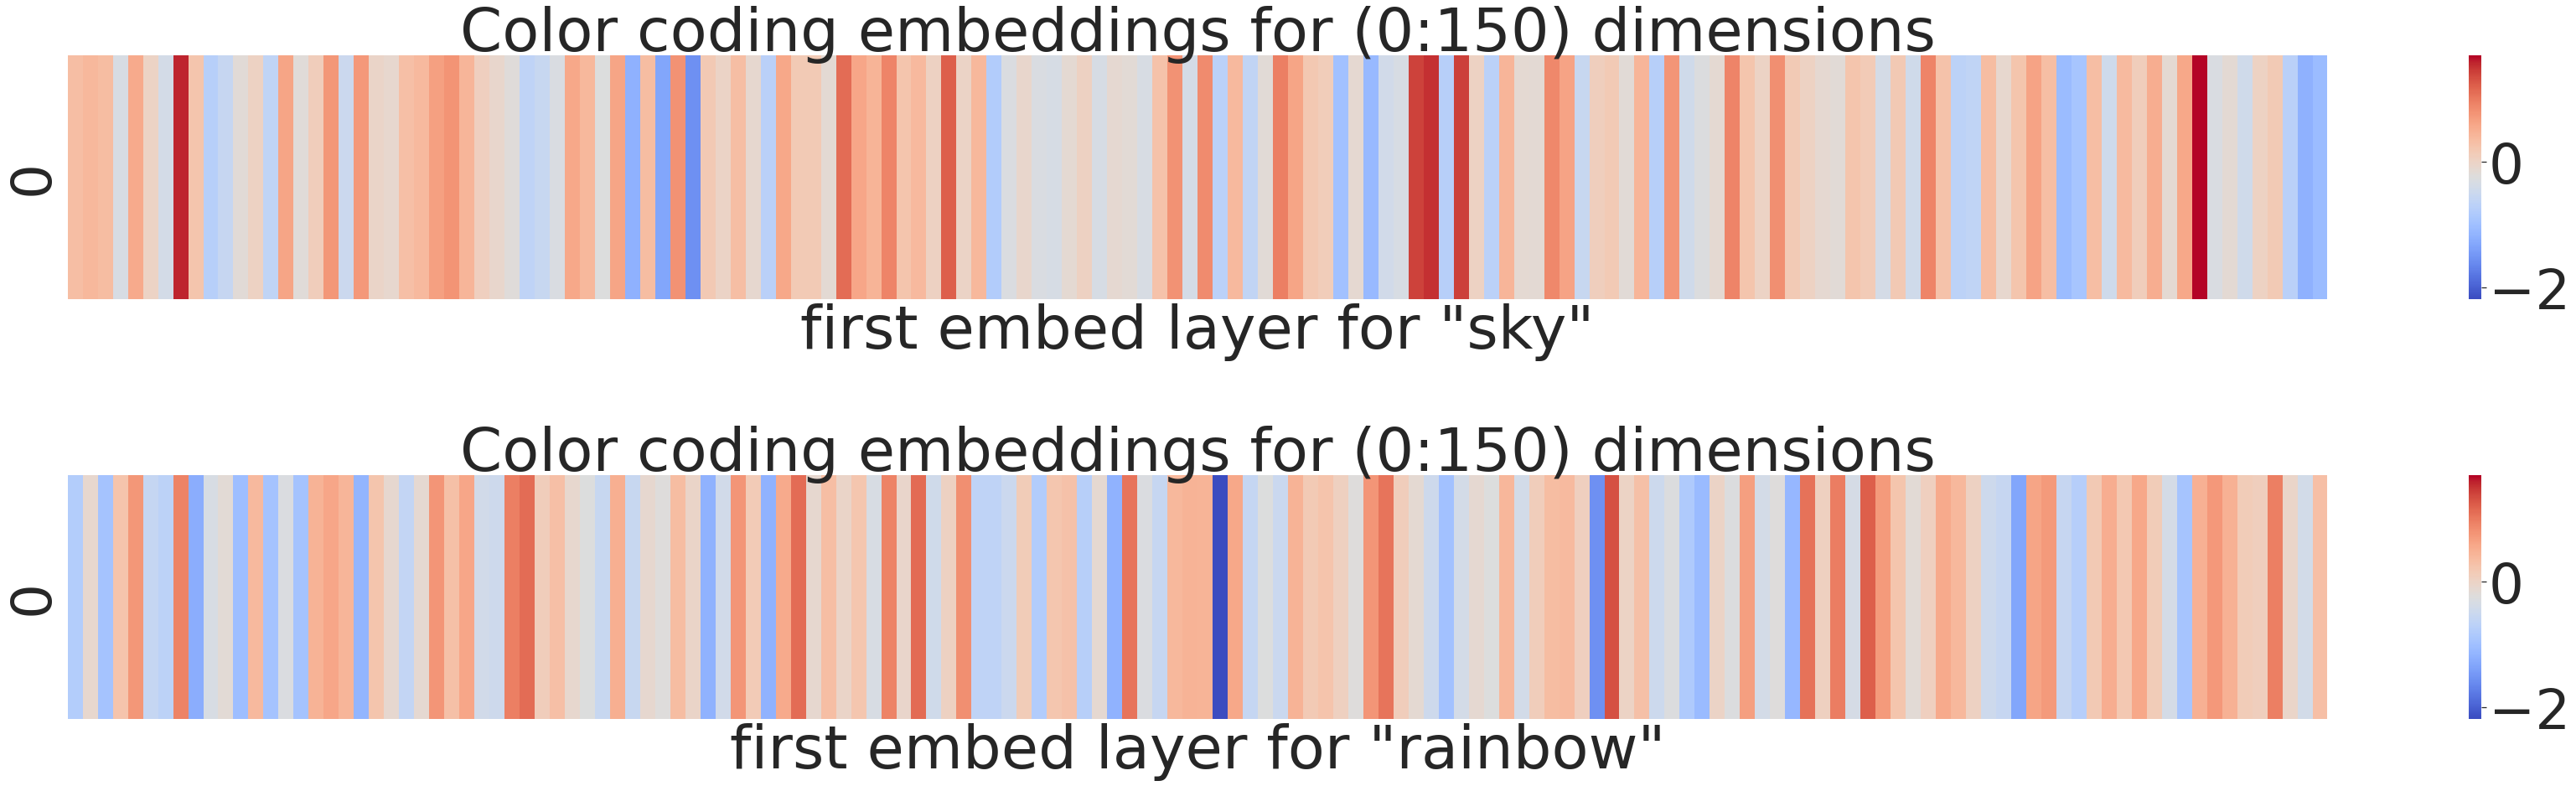

In [ ]:
alt_sentence_2 = ["after","the","rain","a","beautiful","rainbow","spread","across","the","sky"]
alt_s1_word_index = 9
args["tokenized_input"] = extract_embeddings.get_tokenized_input(tokenizer,alt_sentence_2)
args["token_index"] = alt_s1_word_index+1
alt_s1_embed = extract_embeddings.get_token_embed(**args)

alt_s2_word_index = 5
args["token_index"] = alt_s2_word_index+1
alt_s2_embed = extract_embeddings.get_token_embed(**args)

alt_embeds = [alt_s1_embed, alt_s2_embed]
viz = {
    "embeddings":[x[0:150] for x in alt_embeds],
    "layer_display_names":["first embed layer"]*2,
    "words":[alt_sentence_2[alt_s1_word_index], alt_sentence_2[alt_s2_word_index]],
    "title":"Color coding embeddings for (0:150) dimensions",
    "save":False,
    "mode":"compare"
}
graph.plot_embeds(**viz)


<h4>
<li>Now the values in same dimensions don't look so similar anymore</li>
<li>Choice of which layers to use for constructing the final token embeddings is subjective but popular choice is to use the last 4 layers summed up so let's try that next</li>
</h4>

##Last 4 layers summed up



['the', 'cat', 'is', 'asleep'] is tokenized as {'input_ids': tensor([[ 101, 1996, 4937, 2003, 6680,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[ 101, 1996, 4937, 2003, 6680,  102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1]])
[CLS] the cat is asleep [SEP]


['the', 'cat', 'is', 'awake'] is tokenized as {'input_ids': tensor([[ 101, 1996, 4937, 2003, 8300,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[ 101, 1996, 4937, 2003, 8300,  102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1]])
[CLS] the cat is awake [SEP]
min =  -25.802673
max =  7.26983


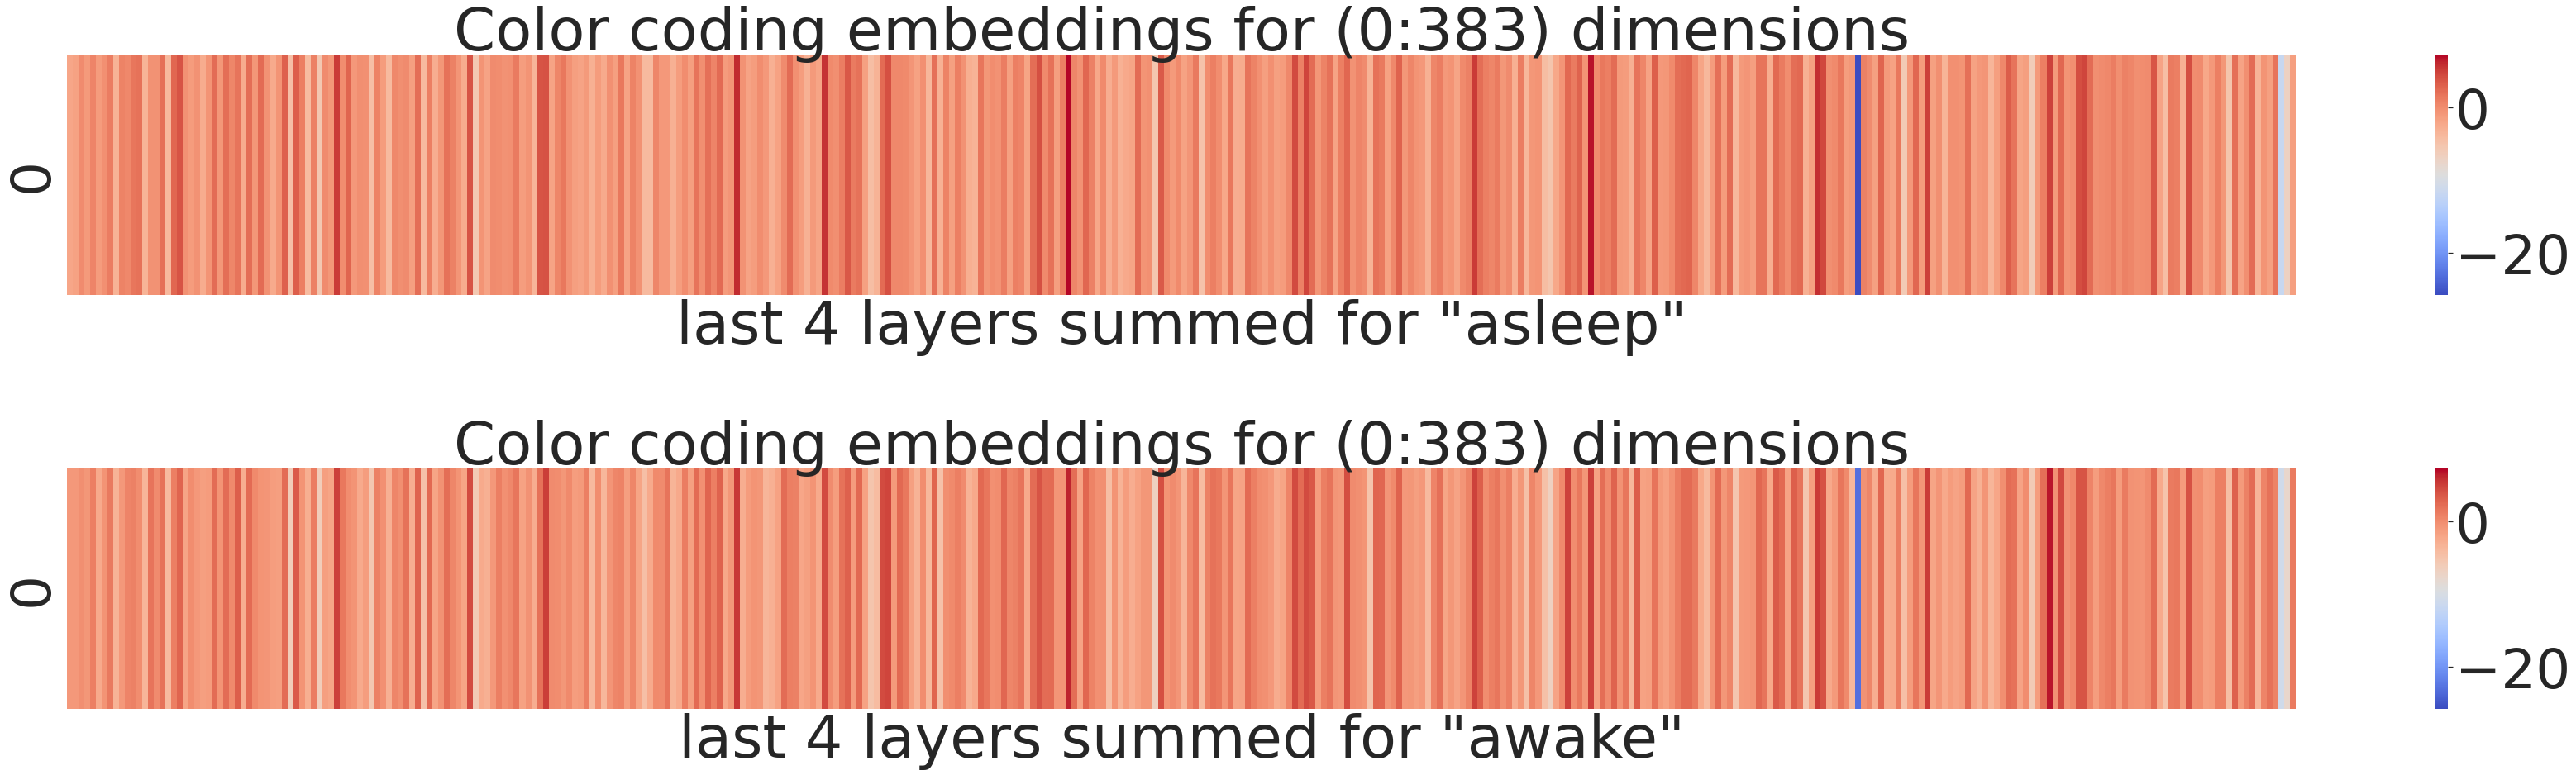

min =  -6.274111
max =  6.887386


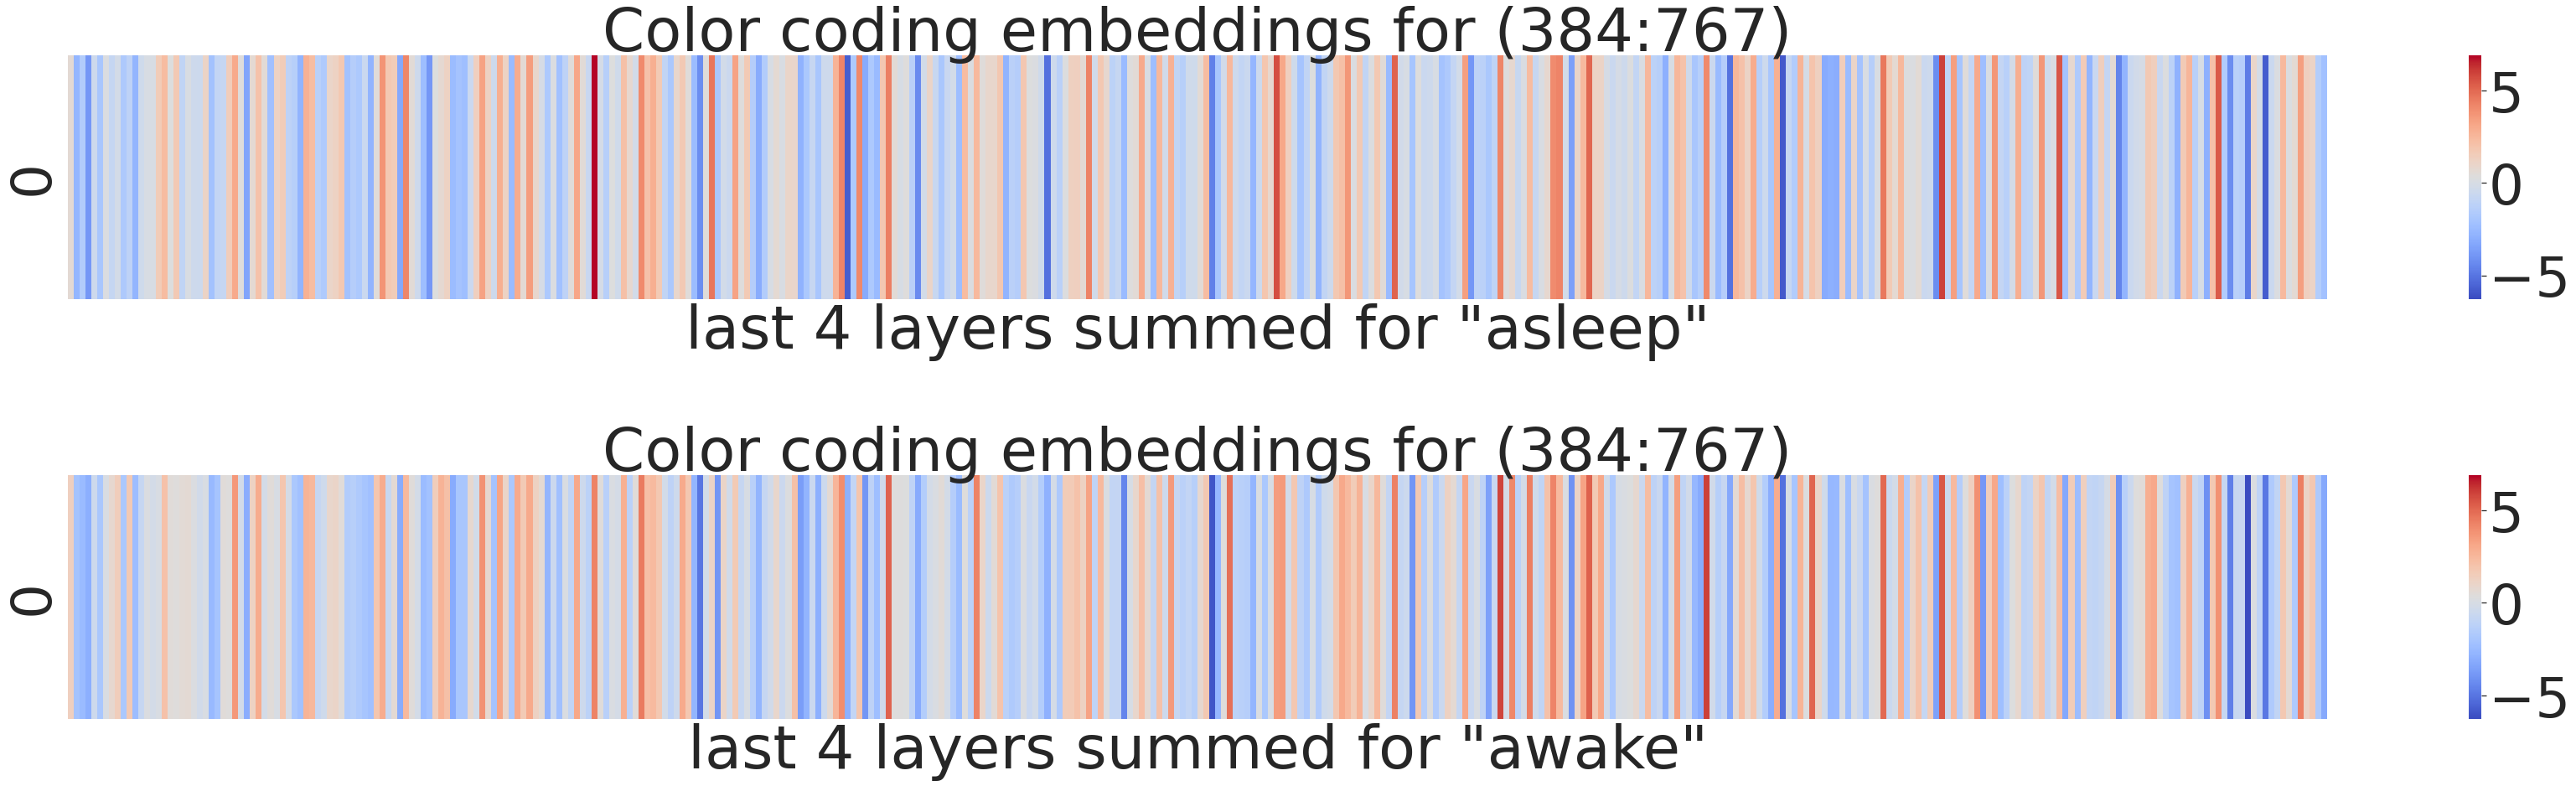

In [ ]:
#Input sentences
sentence_1 = ["the","cat","is","asleep"]
sentence_2 = ["the","cat","is","awake"]

s1_word_index = 3
s2_word_index = 3

args = {
    "model":model,
    "tokenized_input":extract_embeddings.get_tokenized_input(tokenizer,sentence_1),
    "token_index":s1_word_index+1,
    "last_N":4
}

summed_s1_embed = extract_embeddings.get_sum_last_N_layers(**args)

args["tokenized_input"] = extract_embeddings.get_tokenized_input(tokenizer,sentence_2)
args["token_index"] = s2_word_index+1
args["last_N"] = 4

summed_s2_embed = extract_embeddings.get_sum_last_N_layers(**args)

summed_embeds = [summed_s1_embed, summed_s2_embed]
viz = {
    "embeddings":[x[0:384] for x in summed_embeds],
    "layer_display_names":["last {} layers summed".format(args["last_N"])]*2,
    "words":[sentence_1[s1_word_index], sentence_2[s2_word_index]],
    "title":"Color coding embeddings for (0:383) dimensions",
    "save":False,
    "mode":"compare"
}
graph.plot_embeds(**viz)

viz["embeddings"] = [x[384:] for x in summed_embeds]
viz["title"] = "Color coding embeddings for (384:767)"
graph.plot_embeds(**viz)

##Comparing the embeddings from the two different strategies

<h4><li>From what I read, using direct token embeds from BERT to compare tokens in general isn't always very accurate. Since the token embeds depend on context, so same token would've different embed depending on neighboring tokens and hence the similarity with other tokens would also vary. Sentence embeddings however, can be used for comparison. </li>
<li>Let us see what is the similarity values we get from the 2 different embeddings - one from direct embedding table and the other the last 4 layers summed up embeddings
</h4>

<h4> Cosine similarity between awake and asleep embeddings from embedding table</h4>

In [ ]:
cosine_similarity(fl_embeds) 

array([[0.9999998 , 0.41586745],
       [0.41586745, 1.0000001 ]], dtype=float32)

<h4> Cosine similarity between awake and asleep embeddings from last 4 layers summed </h4>

In [ ]:
cosine_similarity(summed_embeds)

array([[1.        , 0.89386564],
       [0.89386564, 0.9999998 ]], dtype=float32)

<h5>
<li>Okay so the word embeddings for awake and asleep have cosine similarity of 0.41 only from the 1st embed layer ( from embedding table ). From POV of English language, makes sense as the words are verbs that describe opposite states of an entity with respect to sleep</li>
<h5>
  <li>The similarity between the words from last layers summed up is 0.89 !! How is this happening ?</li>
  <li>It could be due to this reason - BERT trained for MLM task is supposed to find words that can best replace the [MASK] right ? So after the 12 layers, it would just be selecting words to fill in the blanks. </li>
  <li>Now in the sentence I am ____ we can replace it the blank with either awake or asleep, both words work so in that sense the words are "similar" for the end task the model wants to perform</li>
  <li>In general we are not to use word embeddings from BERT+MLM directly for such similarity comparisons, we can use sentence embeds instead</li>
  <li>So if we compare the same words in different sentence ( and hence with different context ) will the similarity values reduce ? Let's find out. Let's take "lay wide awake with fear" and "lay asleep peacefully" as the new sentences. "Lay wide ____ with fear" can't really be correctly filled in with "asleep" so the 2 words shouldn't be similar in this context</li>
</h5>

In [ ]:
sentence_3 = ["lay","wide","awake","with","fear"]
sentence_4 = ["lay","asleep","peacefully"]

s3_word_index = 2
s4_word_index = 1

args = {
    "model":model,
    "tokenized_input":extract_embeddings.get_tokenized_input(tokenizer,sentence_3),
    "token_index":s3_word_index+1,
    "last_N":4
}

summed_s3_embed = extract_embeddings.get_sum_last_N_layers(**args)

args["tokenized_input"] = extract_embeddings.get_tokenized_input(tokenizer,sentence_4)
args["token_index"] = s4_word_index+1

summed_s4_embed = extract_embeddings.get_sum_last_N_layers(**args)


print("\n\nCosine similarity: \n", cosine_similarity([summed_s3_embed, summed_s4_embed]))



['lay', 'wide', 'awake', 'with', 'fear'] is tokenized as {'input_ids': tensor([[ 101, 3913, 2898, 8300, 2007, 3571,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[ 101, 3913, 2898, 8300, 2007, 3571,  102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1, 1]])
[CLS] lay wide awake with fear [SEP]


['lay', 'asleep', 'peacefully'] is tokenized as {'input_ids': tensor([[  101,  3913,  6680, 21614,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
input_ids = tensor([[  101,  3913,  6680, 21614,   102]])
token_type_ids = tensor([[0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1]])
[CLS] lay asleep peacefully [SEP]


Cosine similarity: 
 [[1.0000002 0.7377006]
 [0.7377006 1.       ]]


<h4>
<li>As expected now "asleep" and "awake" are having a similarity of only 0.74 from the previous value of 0.89
</h4>

##Sentence embeddings



['lay', 'wide', 'awake', 'with', 'fear'] is tokenized as {'input_ids': tensor([[ 101, 3913, 2898, 8300, 2007, 3571,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[ 101, 3913, 2898, 8300, 2007, 3571,  102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1, 1]])
[CLS] lay wide awake with fear [SEP]


['lay', 'asleep', 'peacefully'] is tokenized as {'input_ids': tensor([[  101,  3913,  6680, 21614,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
input_ids = tensor([[  101,  3913,  6680, 21614,   102]])
token_type_ids = tensor([[0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1]])
[CLS] lay asleep peacefully [SEP]
min =  -1.7795963
max =  1.4446315


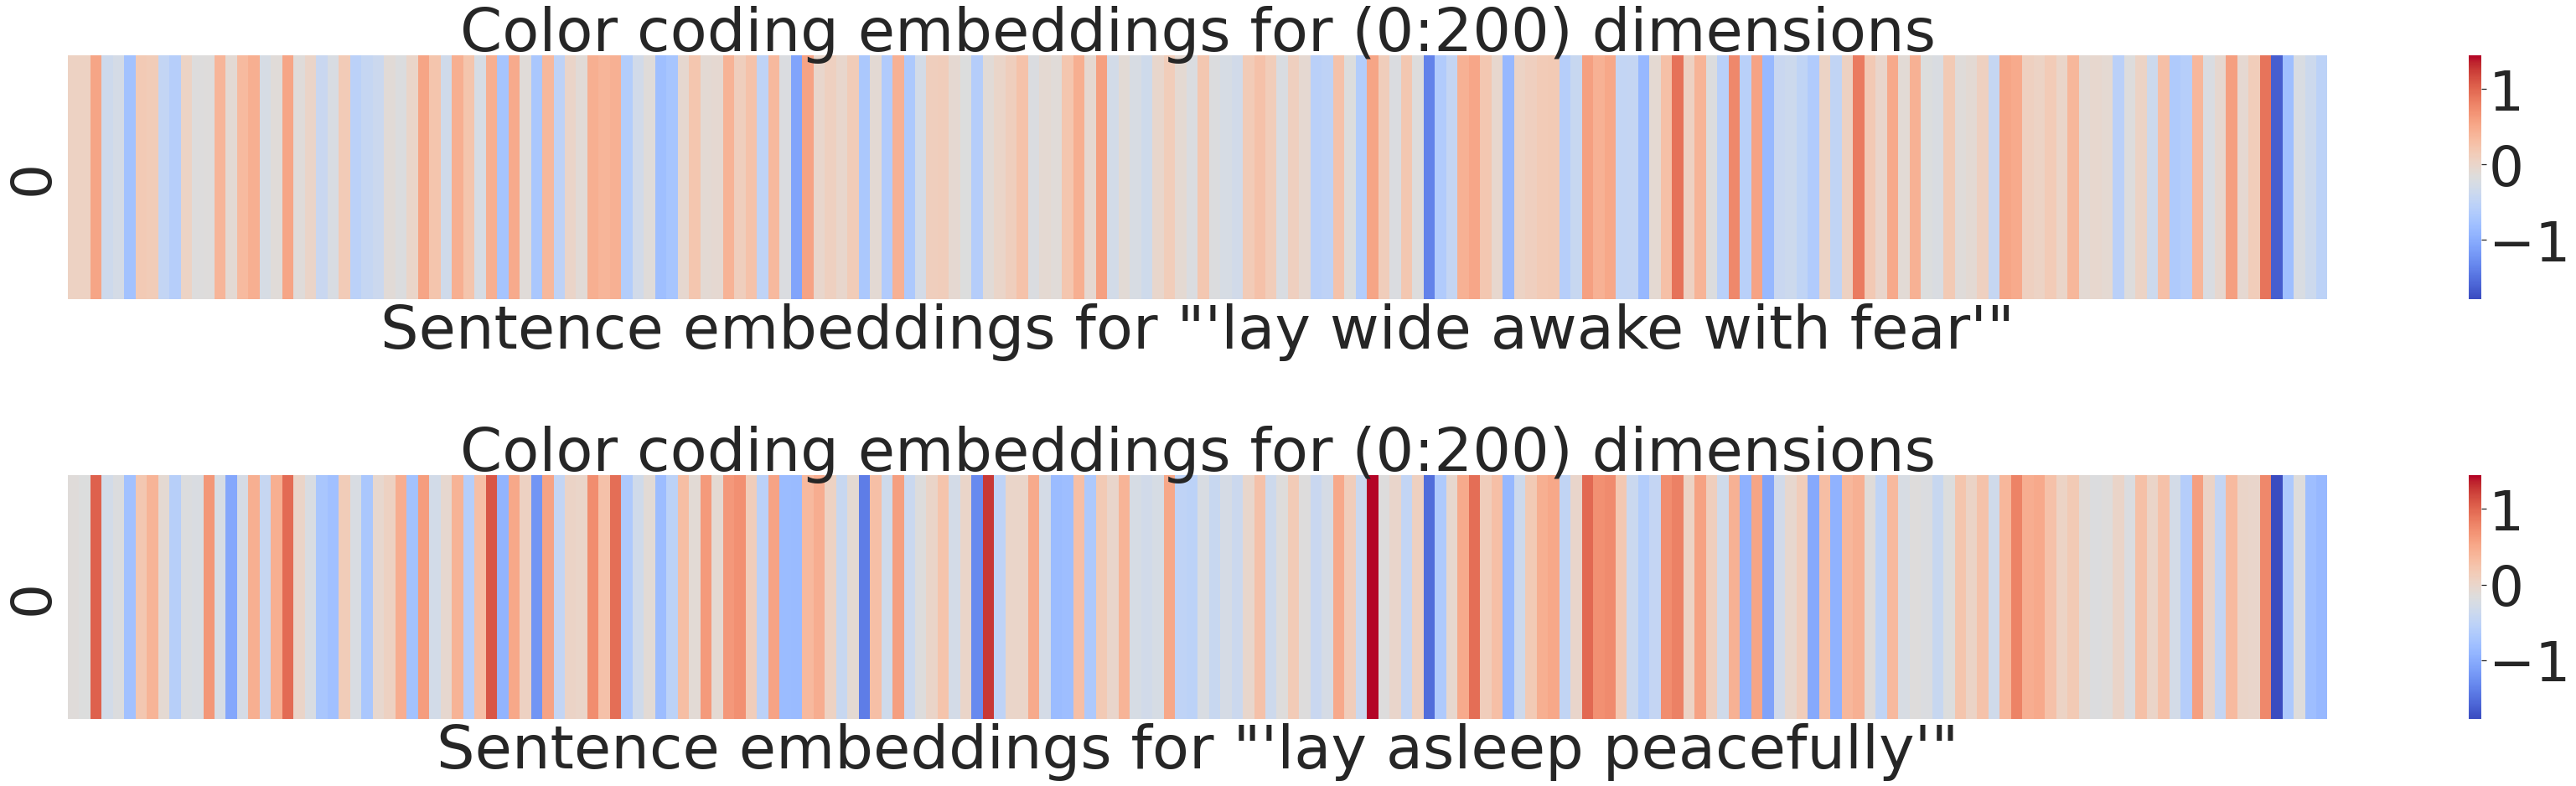

In [ ]:
sentence_3 = ["lay","wide","awake","with","fear"]
sentence_4 = ["lay","asleep","peacefully"]

args = {
    "model":model,
    "tokenized_input":extract_embeddings.get_tokenized_input(tokenizer,sentence_3)
}
s3_sentence_embed = extract_embeddings.get_sentence_embed(**args)

args["tokenized_input"] = extract_embeddings.get_tokenized_input(tokenizer,sentence_4)
s4_sentence_embed = extract_embeddings.get_sentence_embed(**args)

s_embedding = [s3_sentence_embed, s4_sentence_embed]
viz = {
    "embeddings":[x[0:200] for x in s_embedding],
    "layer_display_names":["Sentence embeddings"]*2,
    "words":["\'{}\'".format(" ".join(sentence_3)), \
             "\'{}\'".format(" ".join(sentence_4))],
    "title":"Color coding embeddings for (0:200) dimensions",
    "save":False,
    "mode":"compare"
}
graph.plot_embeds(**viz)

<h4><li>Again the same sort of pattern - values in same dimensions are same - like on right hand side the same orange and deep blue bands for both the sentences, could be it is representing the "commonality" between the sentences - both the sentences are about lying down</li>
<li>The similarity value between the 2 sentences</li>

In [ ]:
cosine_similarity(s_embedding)

array([[0.99999976, 0.83803   ],
       [0.83803   , 0.99999976]], dtype=float32)

##Animated - how embedding values are chaning as it passes through each of the 12 layers



['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog'] is tokenized as {'input_ids': tensor([[  101,  1996,  4248,  2829,  4419,  5598,  2058,  1996, 13971,  3899,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
input_ids = tensor([[  101,  1996,  4248,  2829,  4419,  5598,  2058,  1996, 13971,  3899,
           102]])
token_type_ids = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask = tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
[CLS] the quick brown fox jumped over the lazy dog [SEP]
min =  -2.7509947
max =  2.2858899


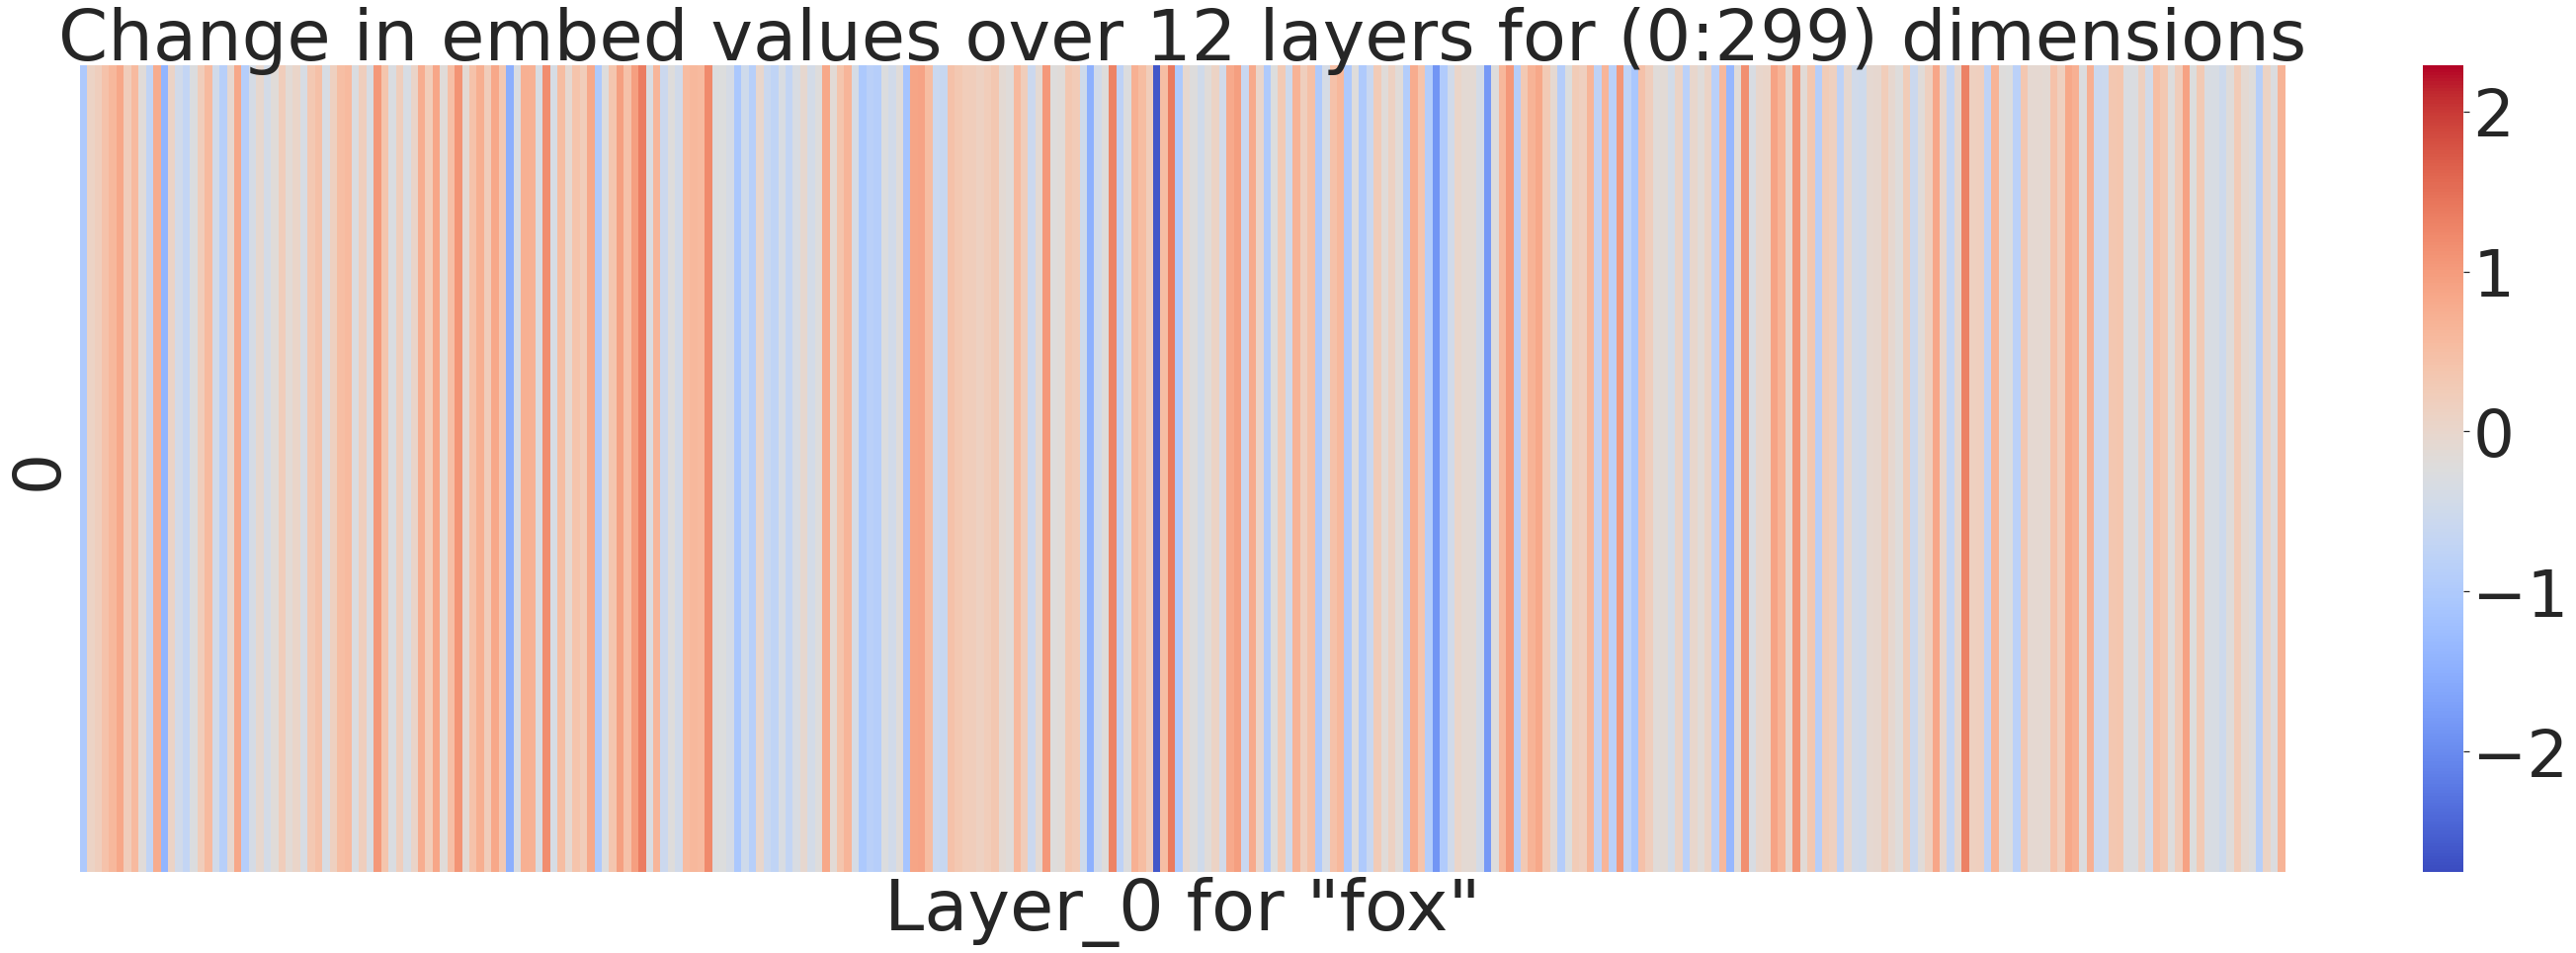

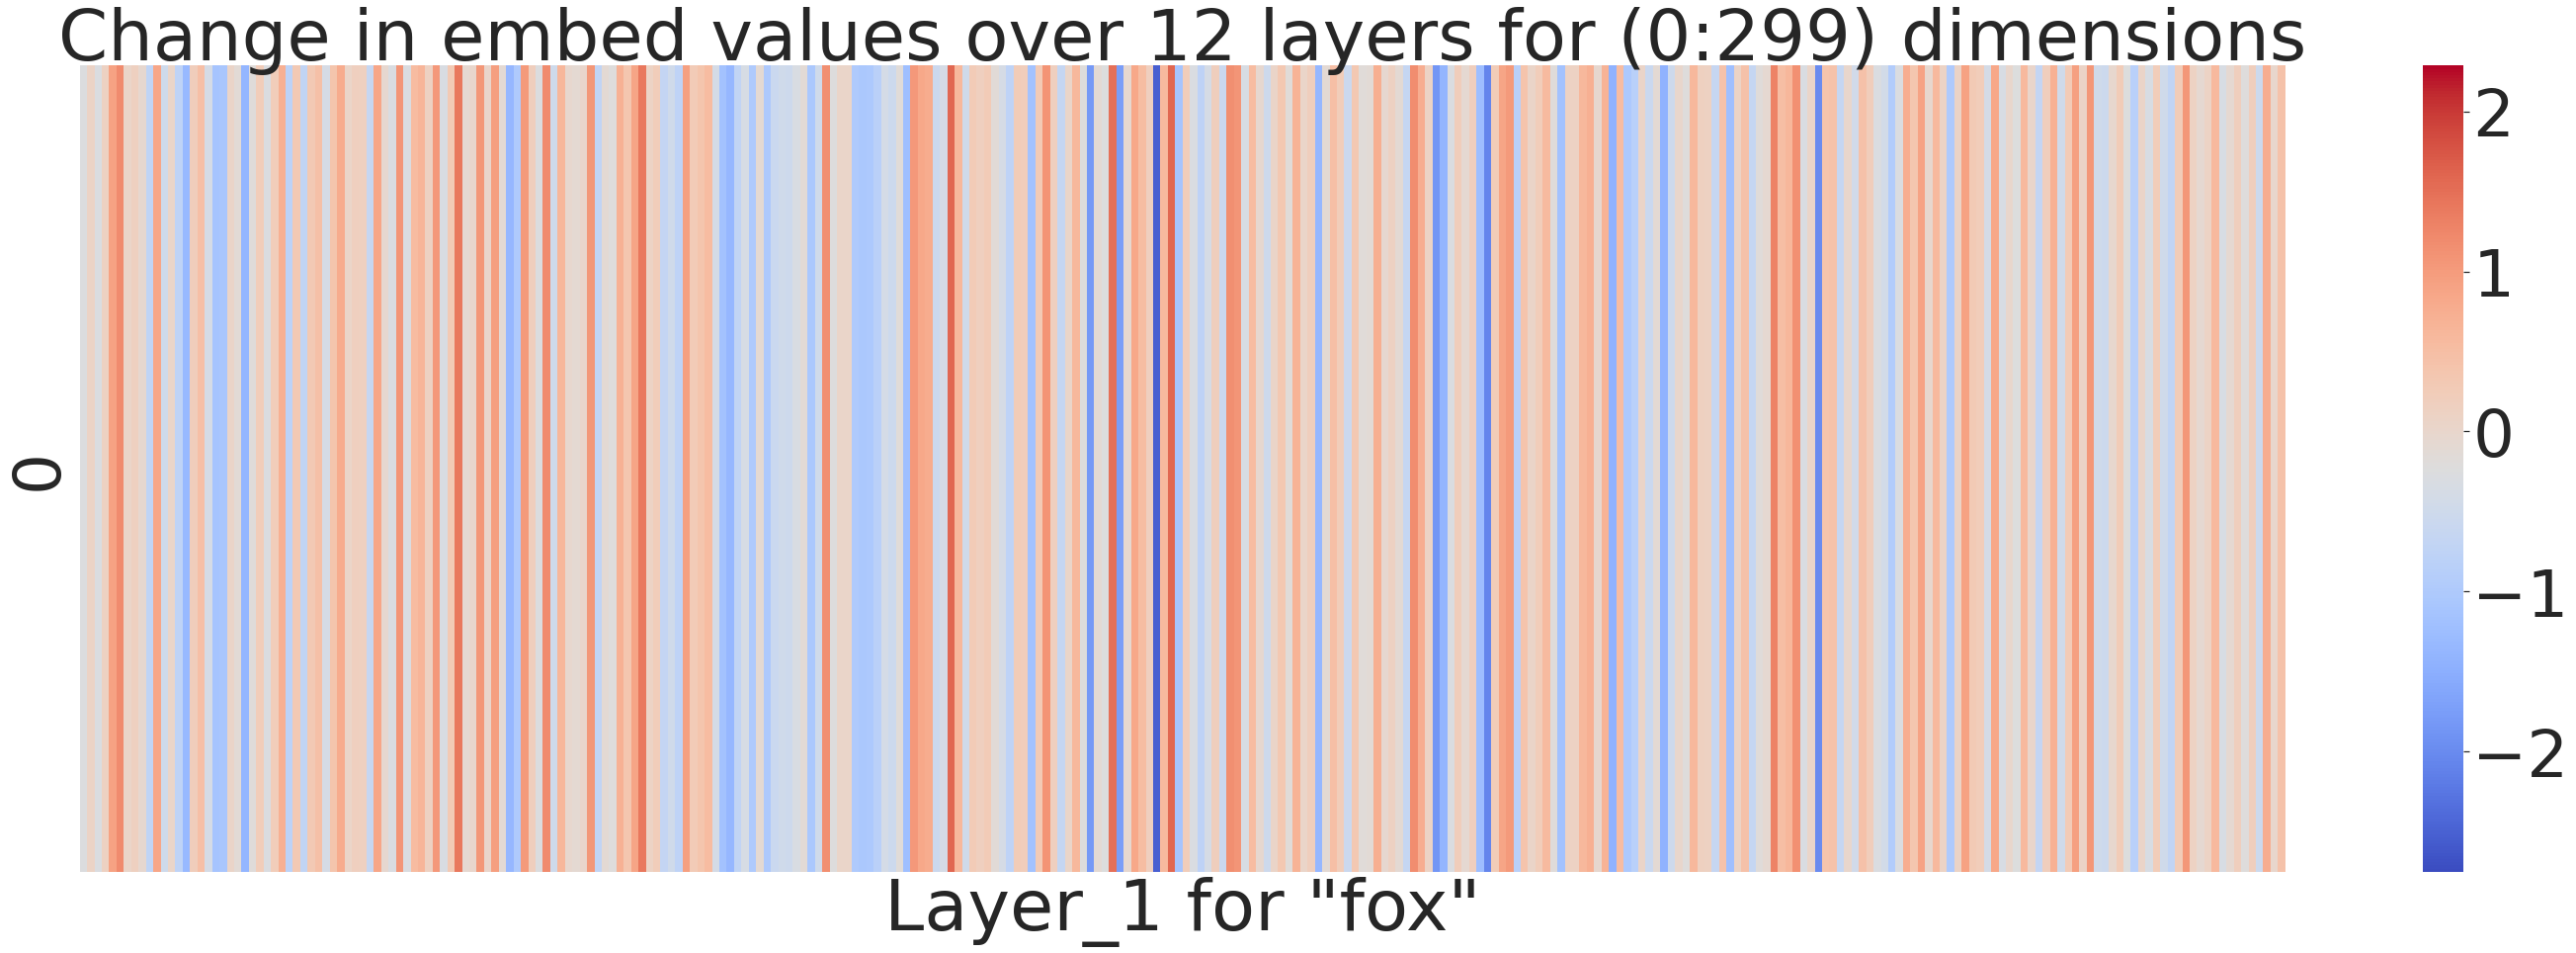

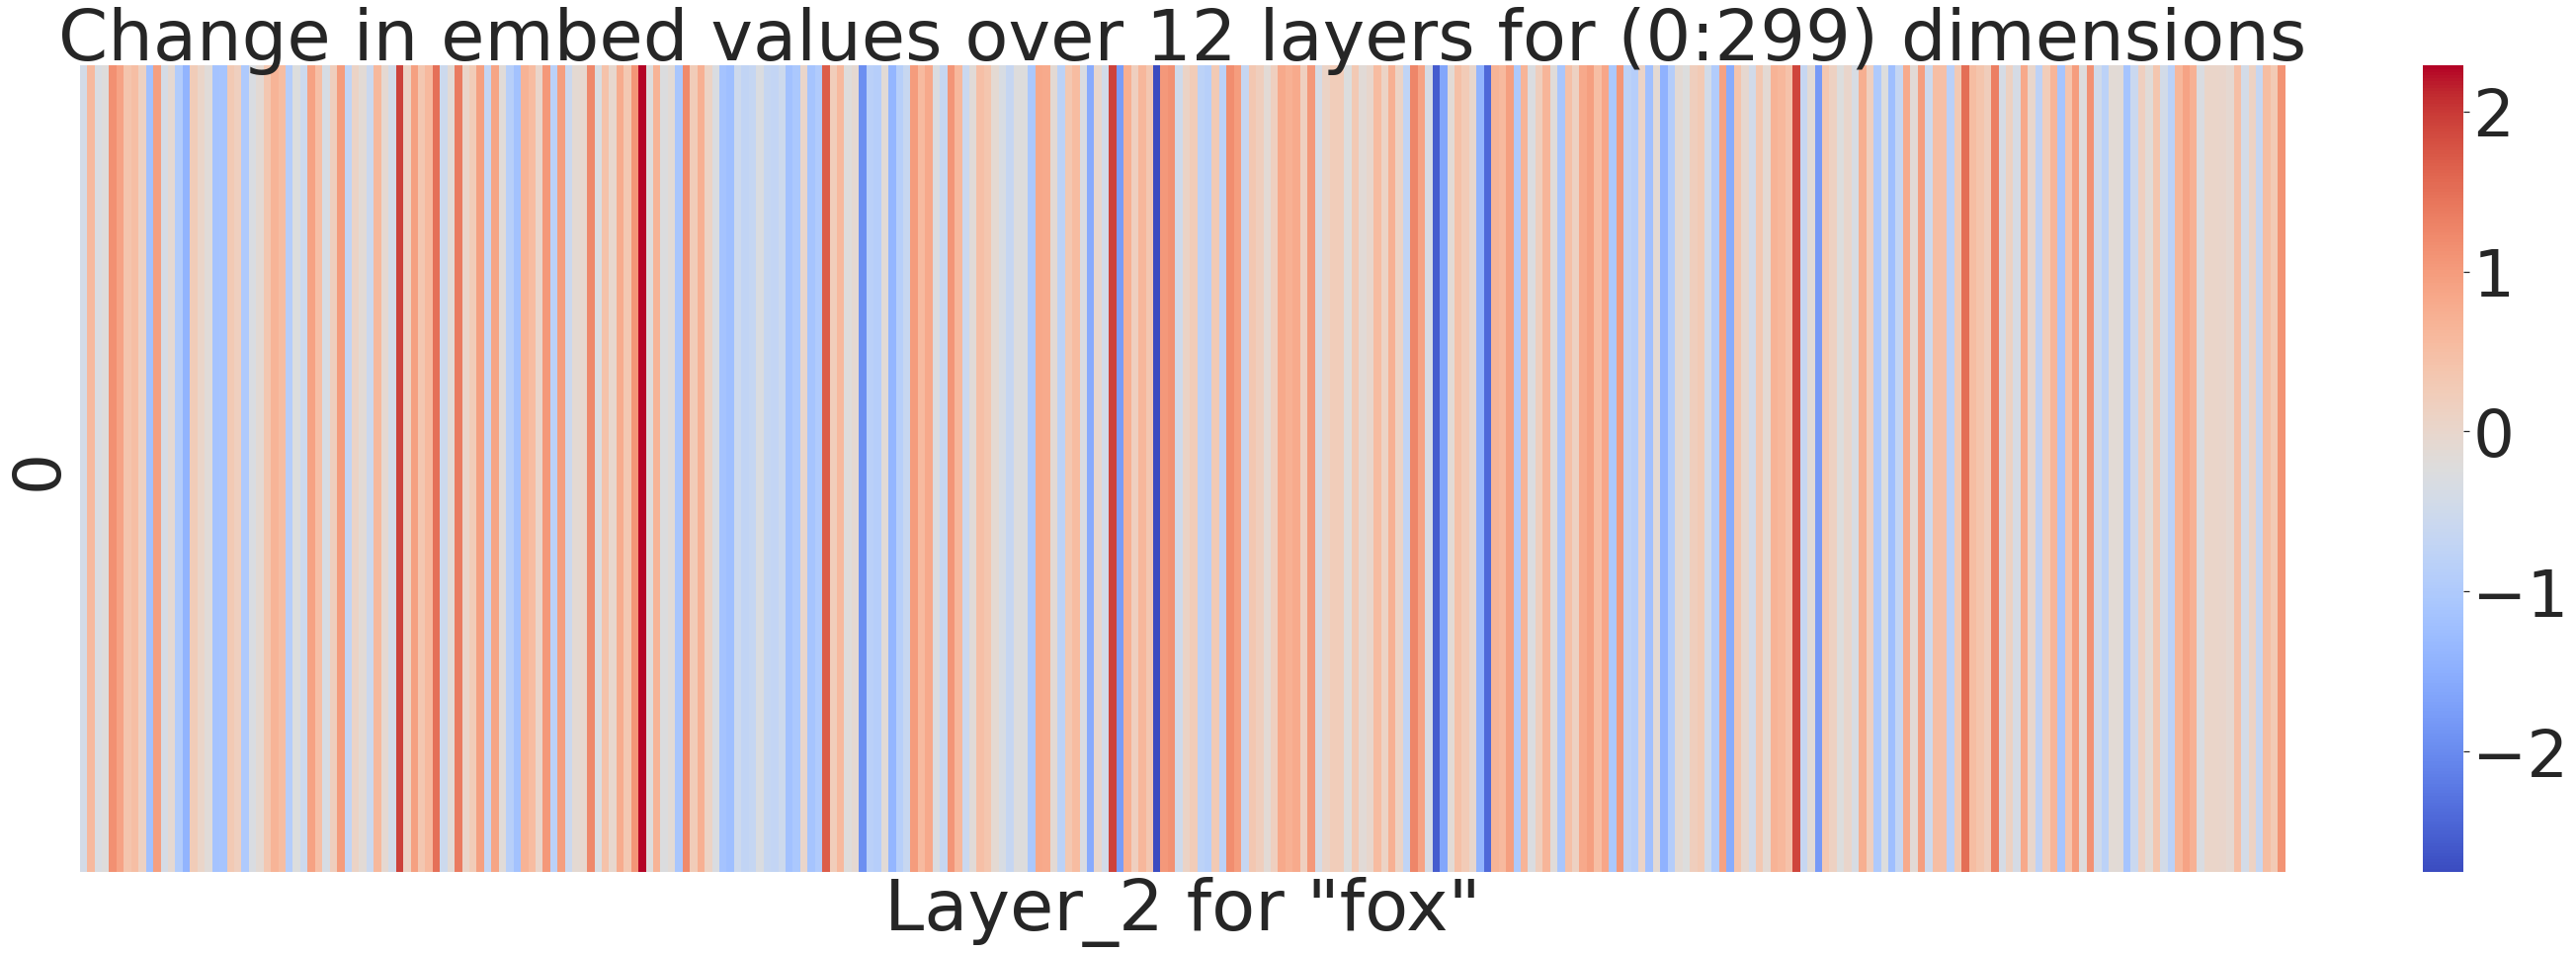

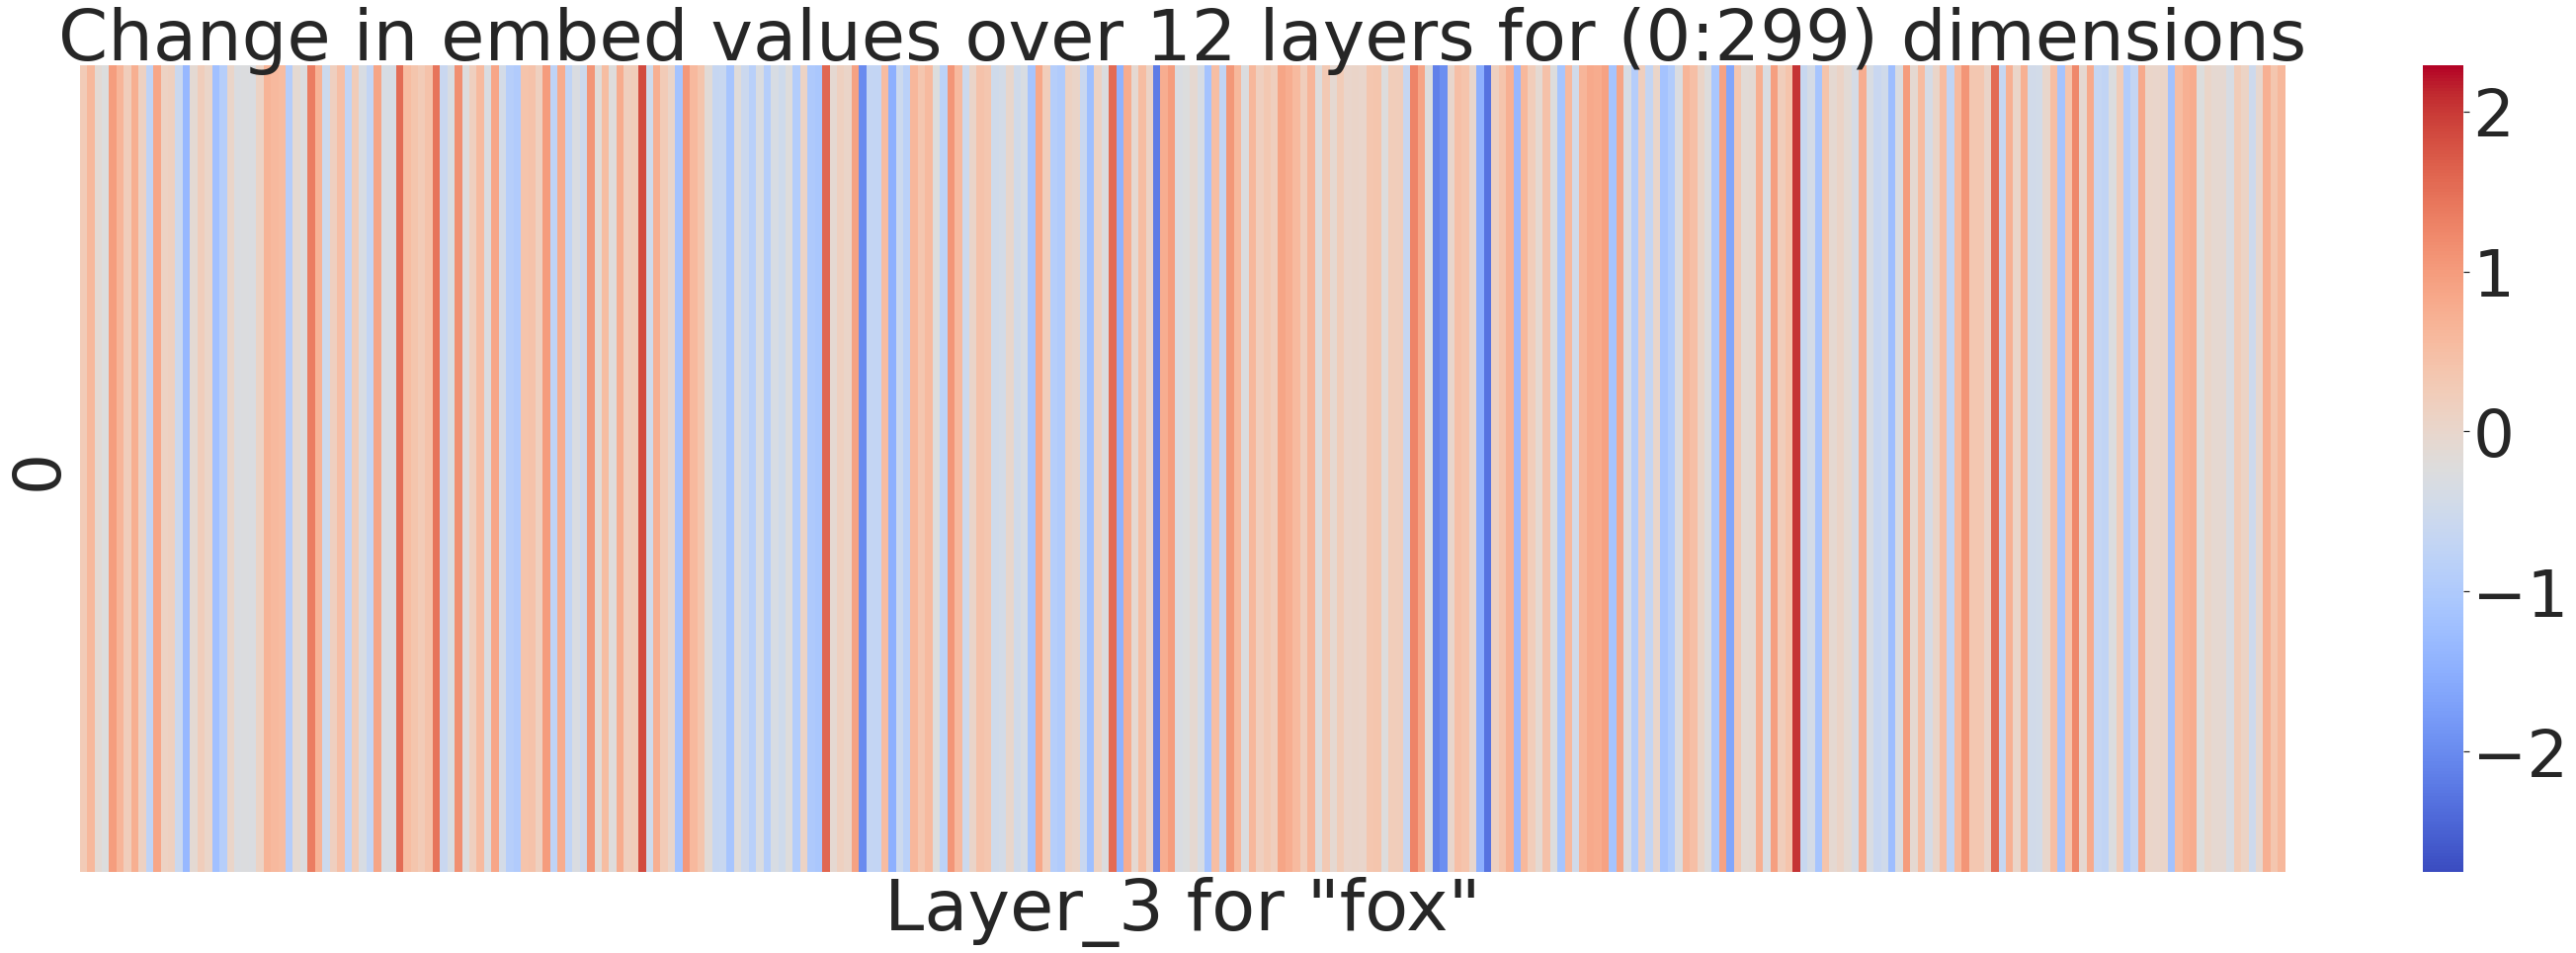

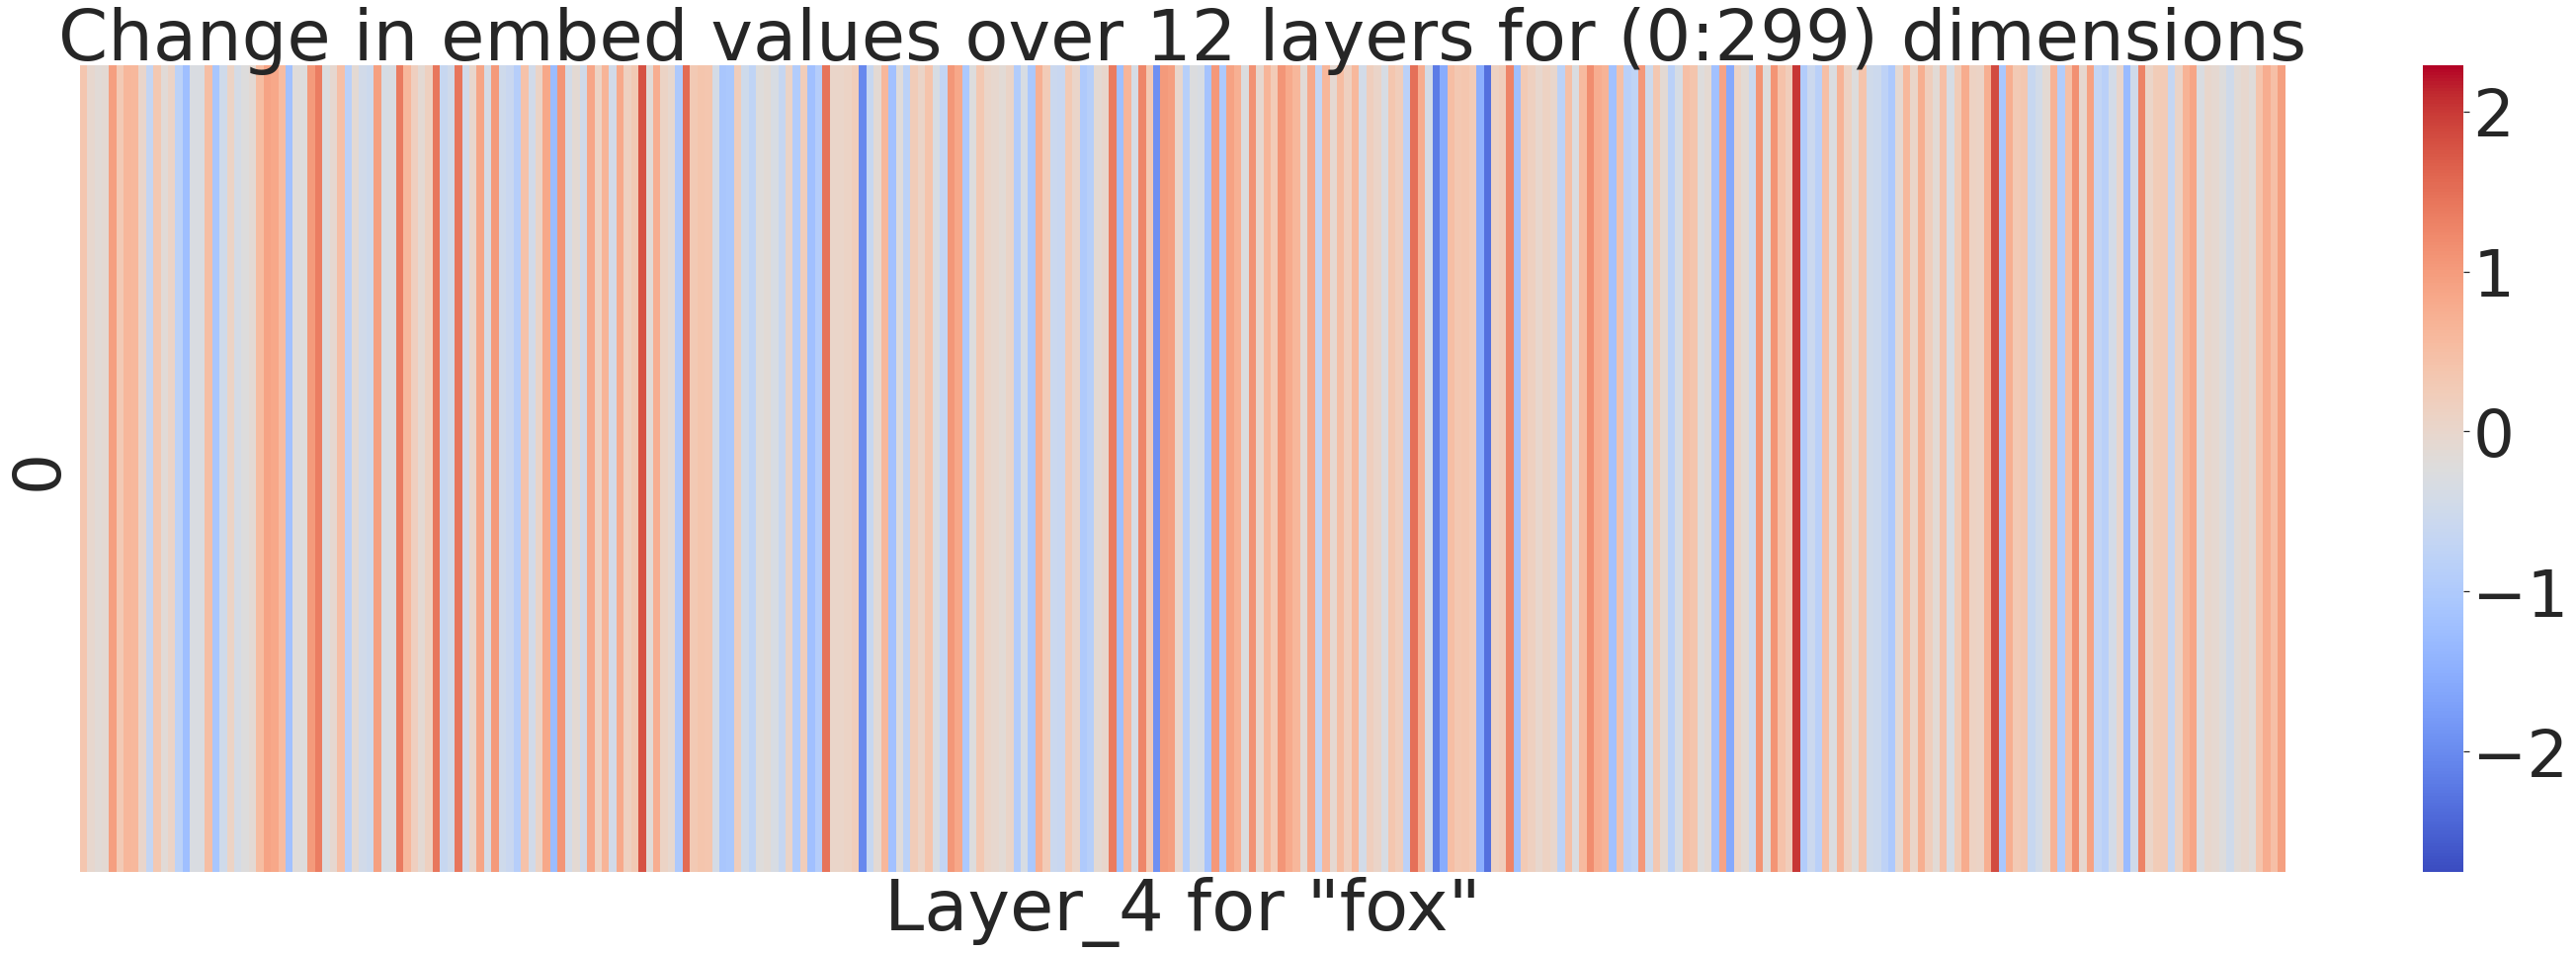

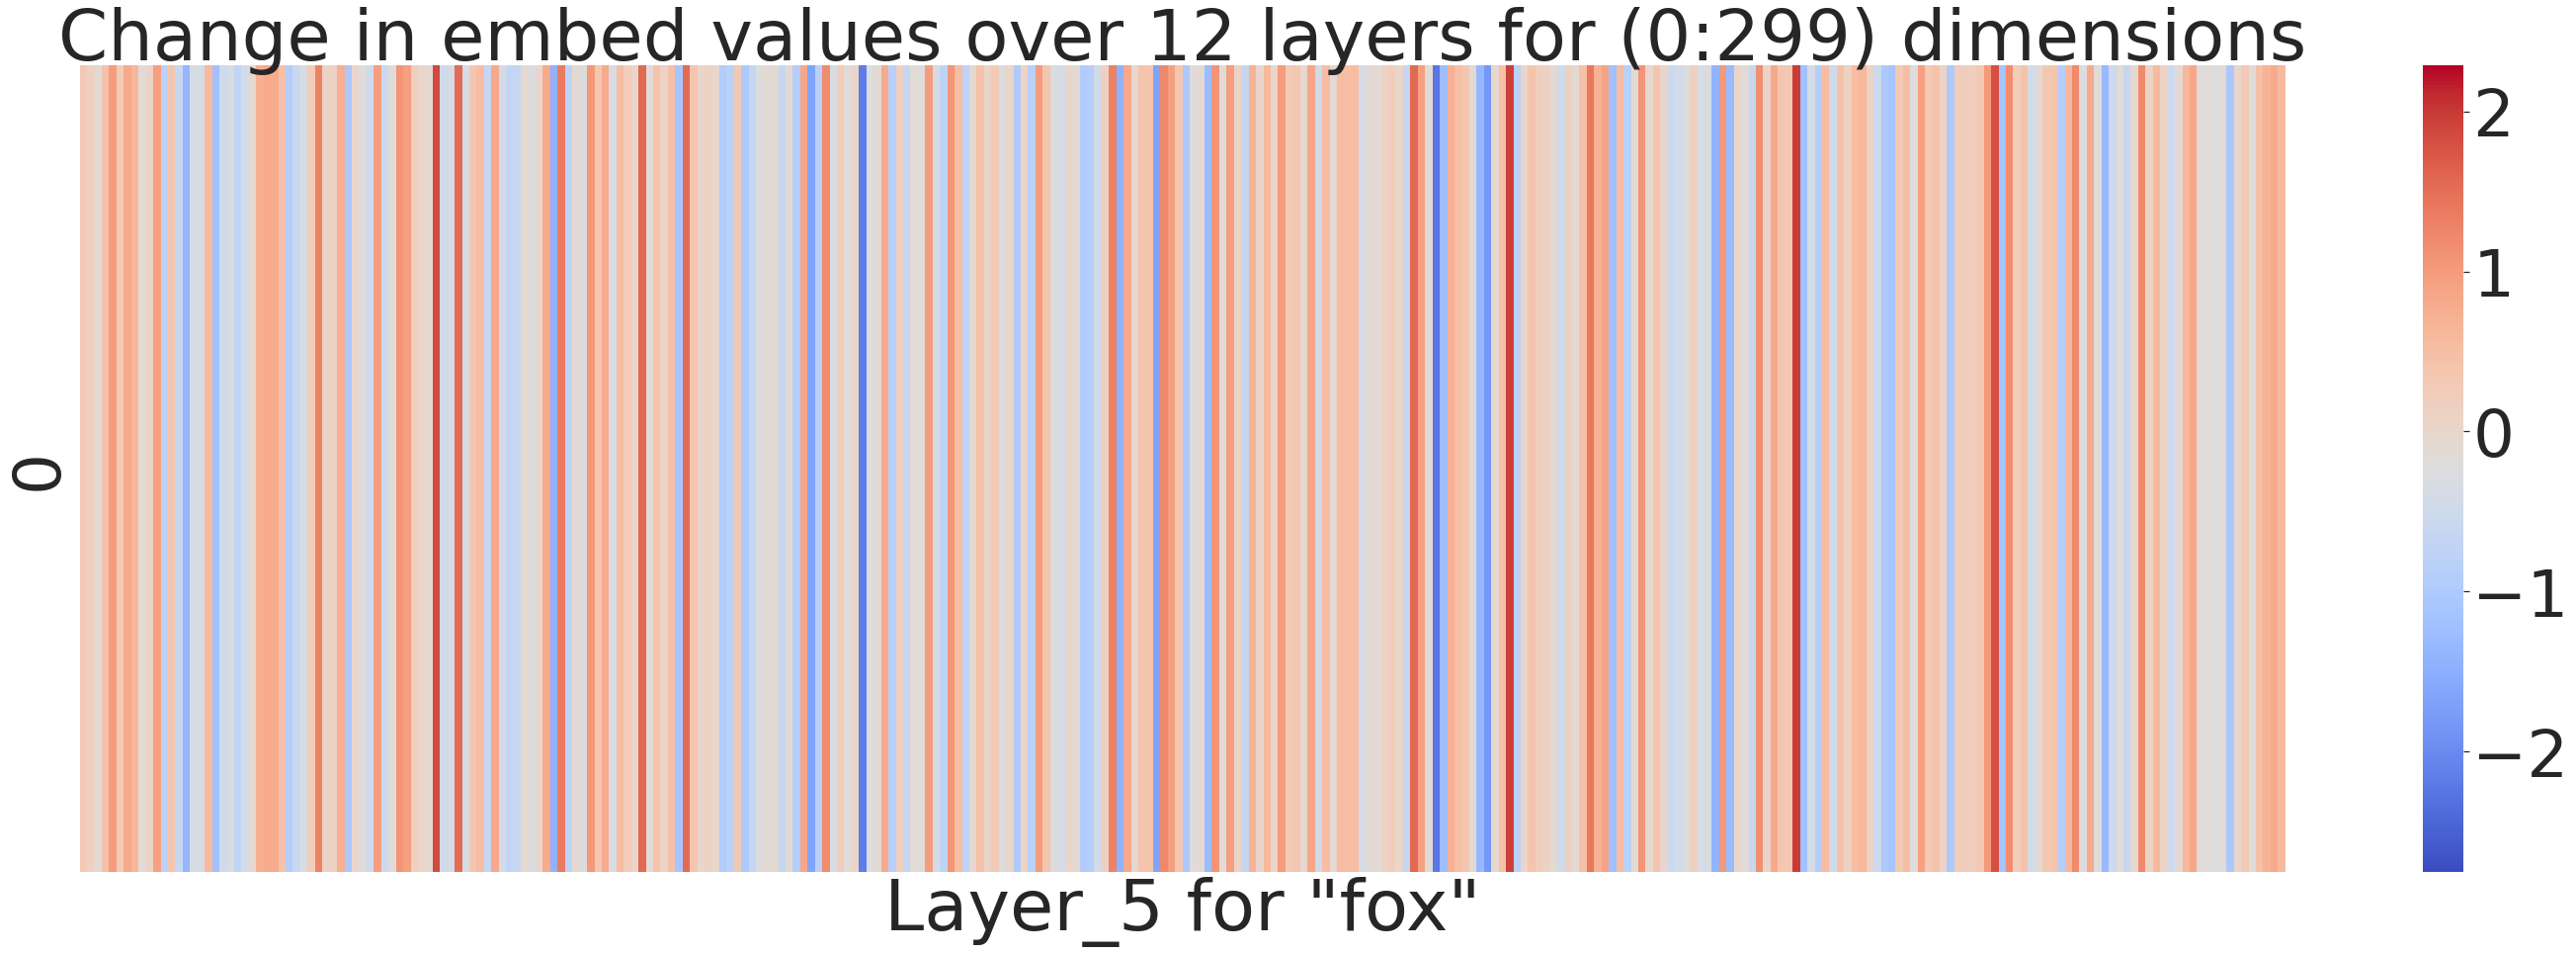

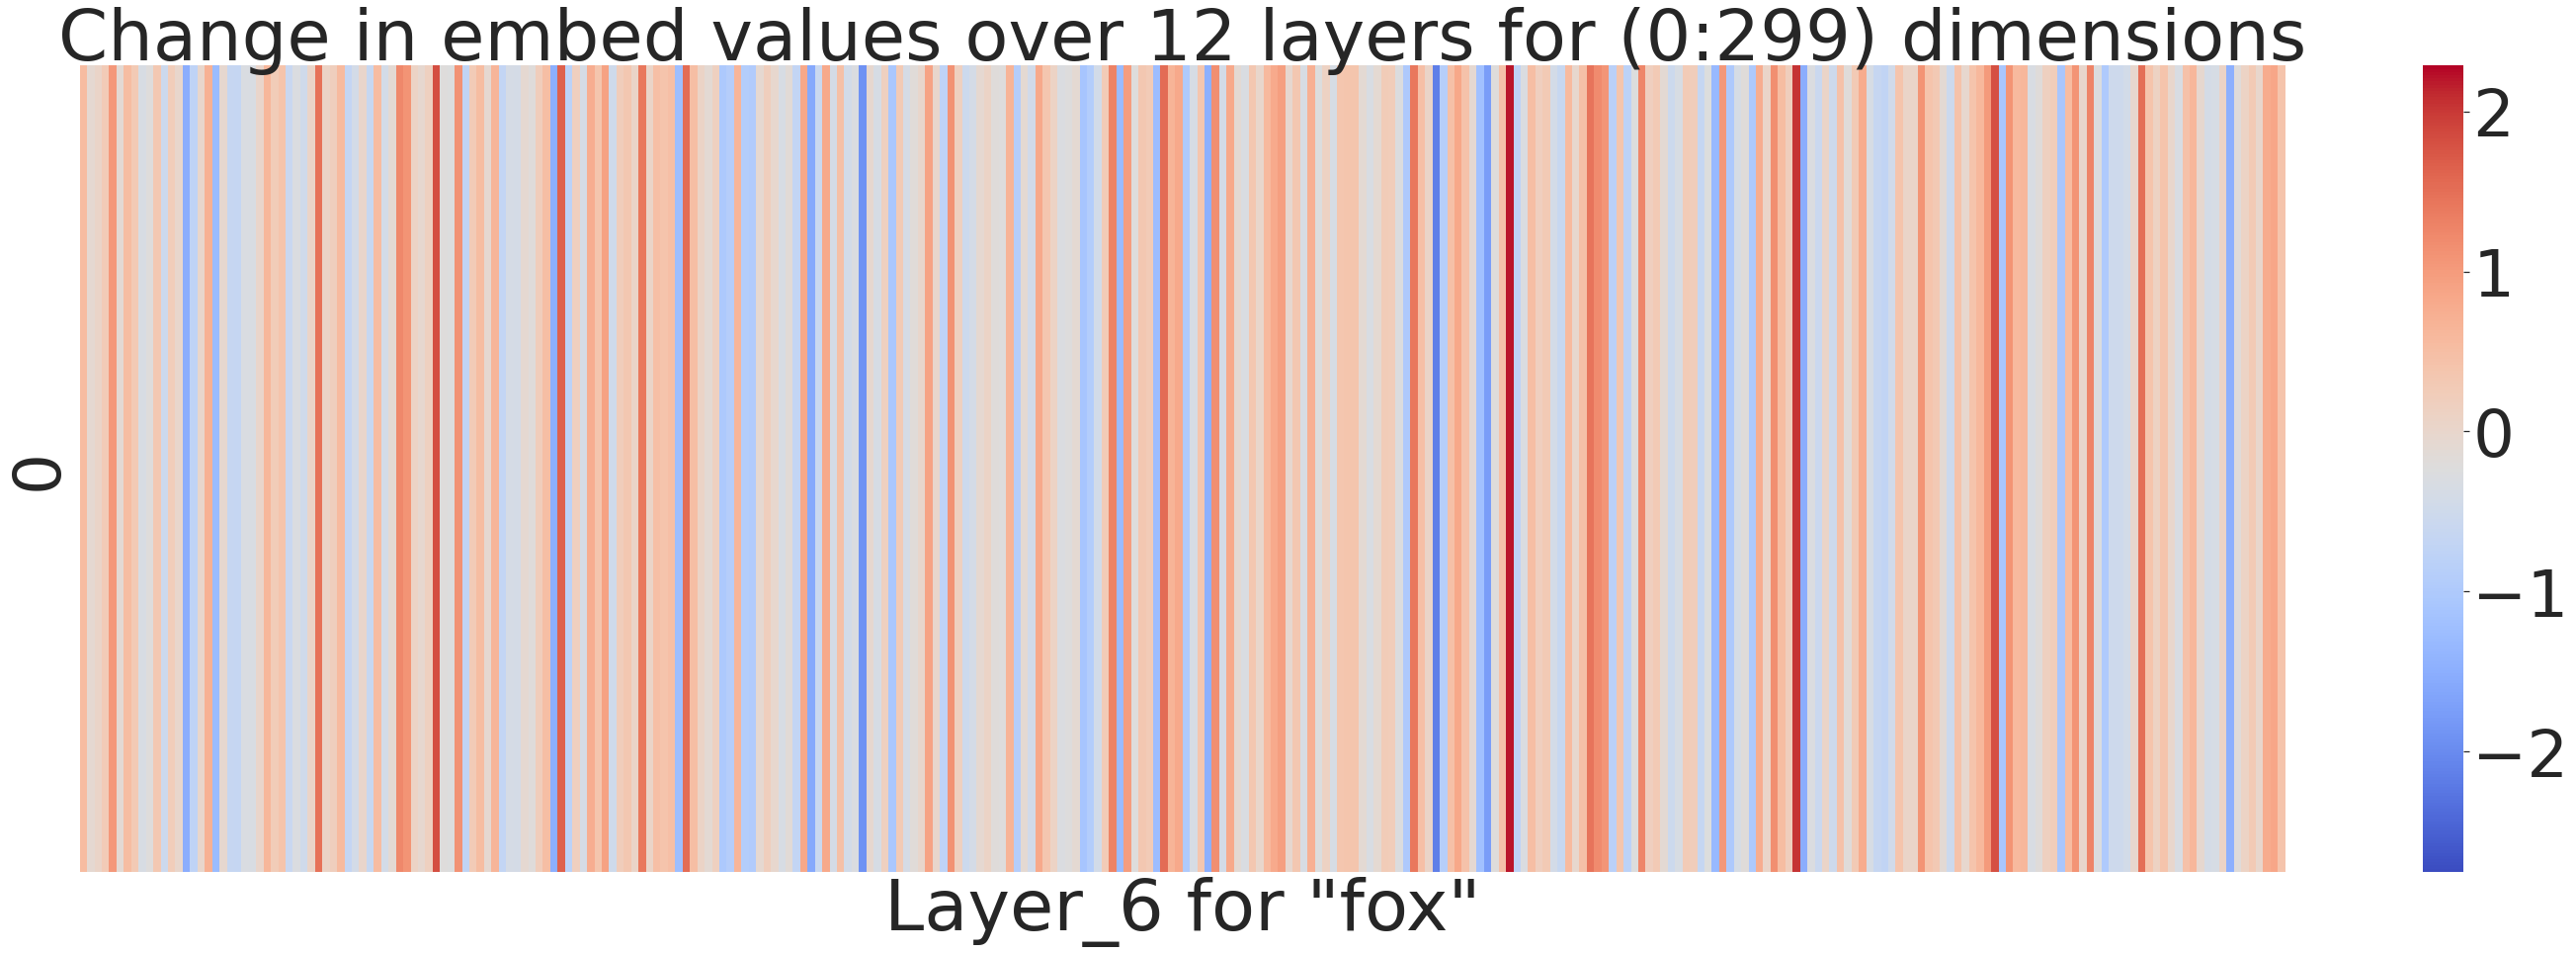

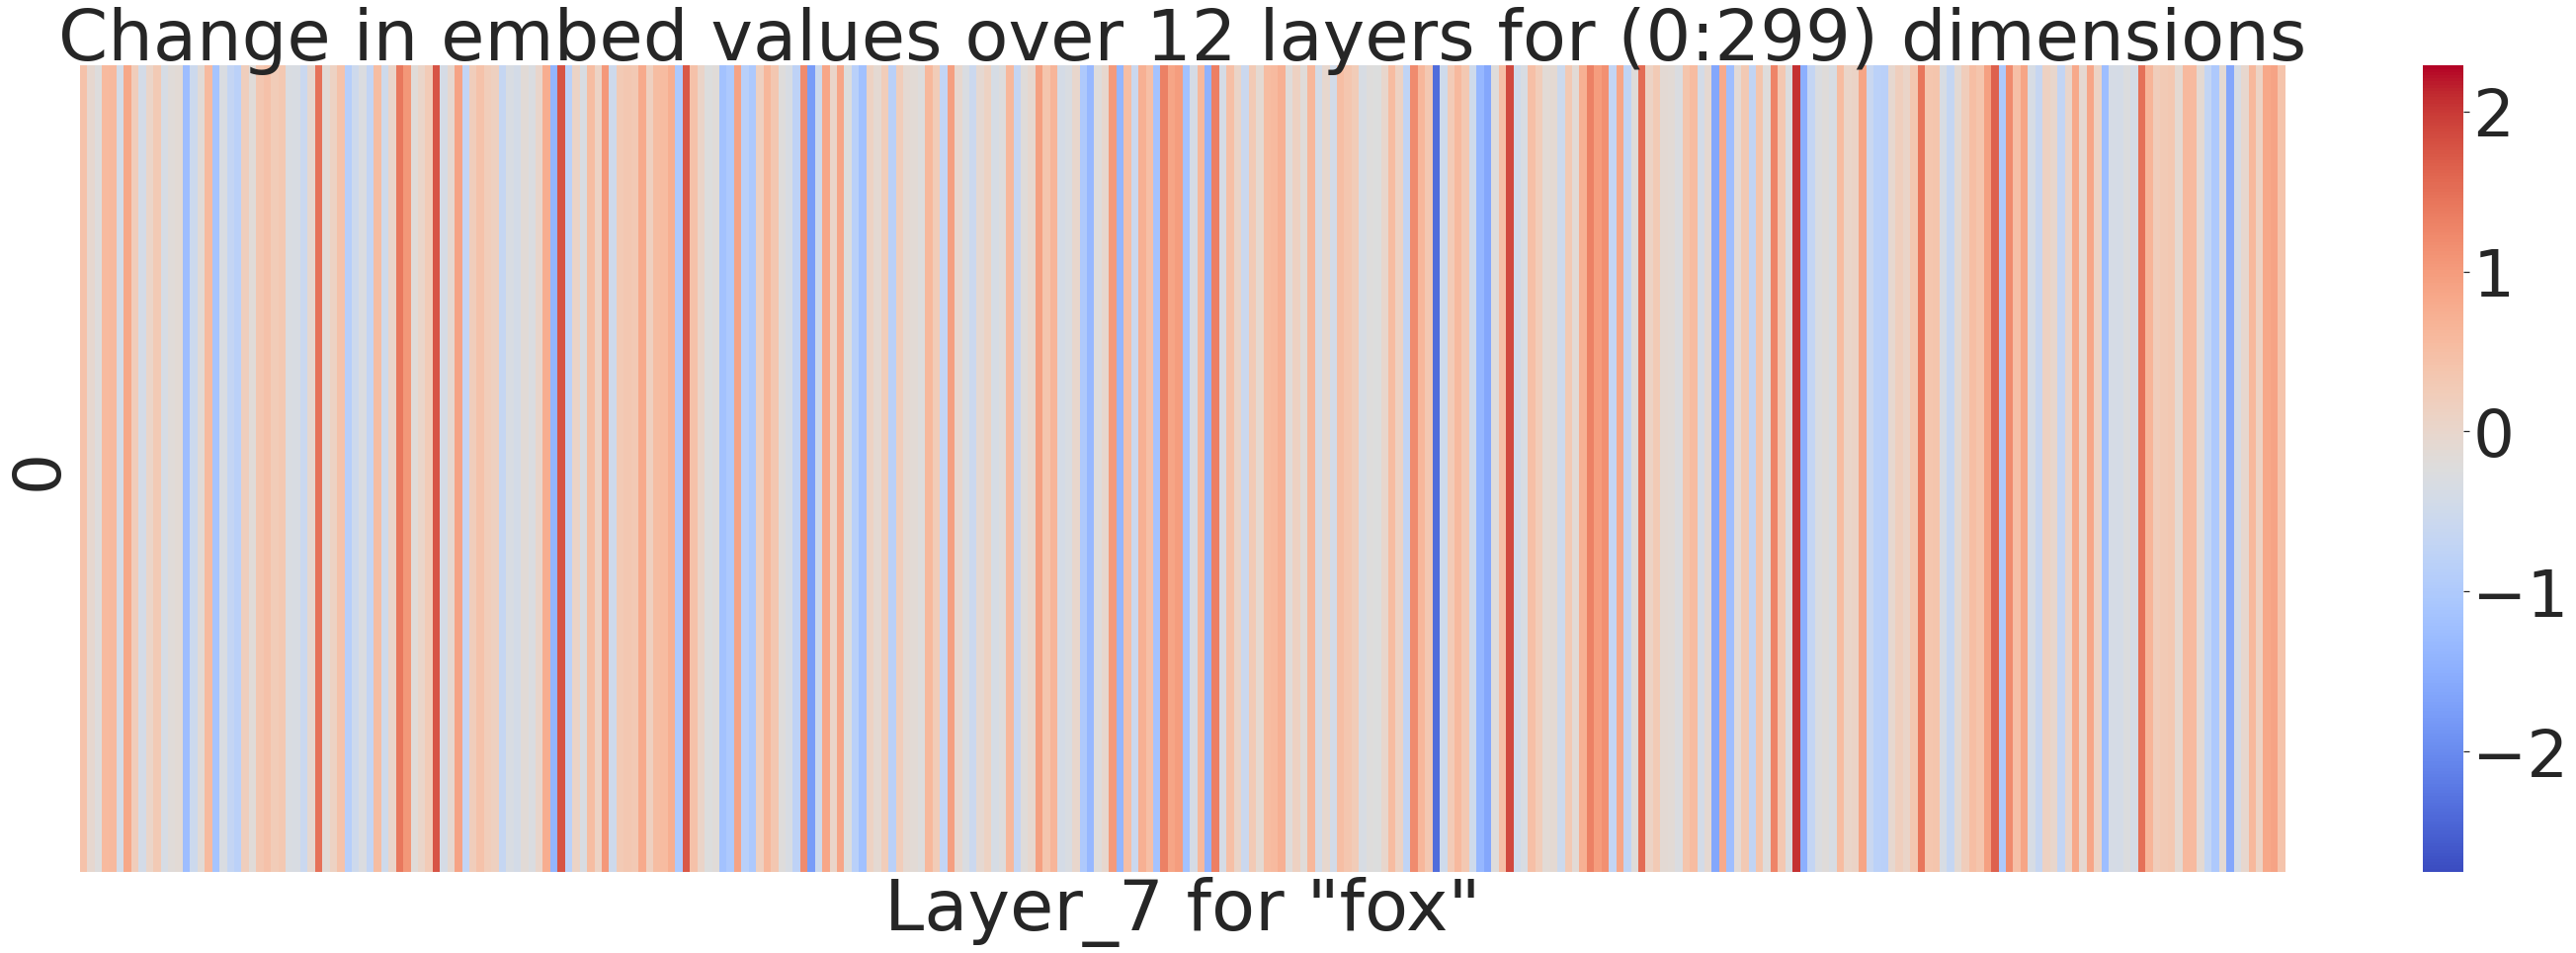

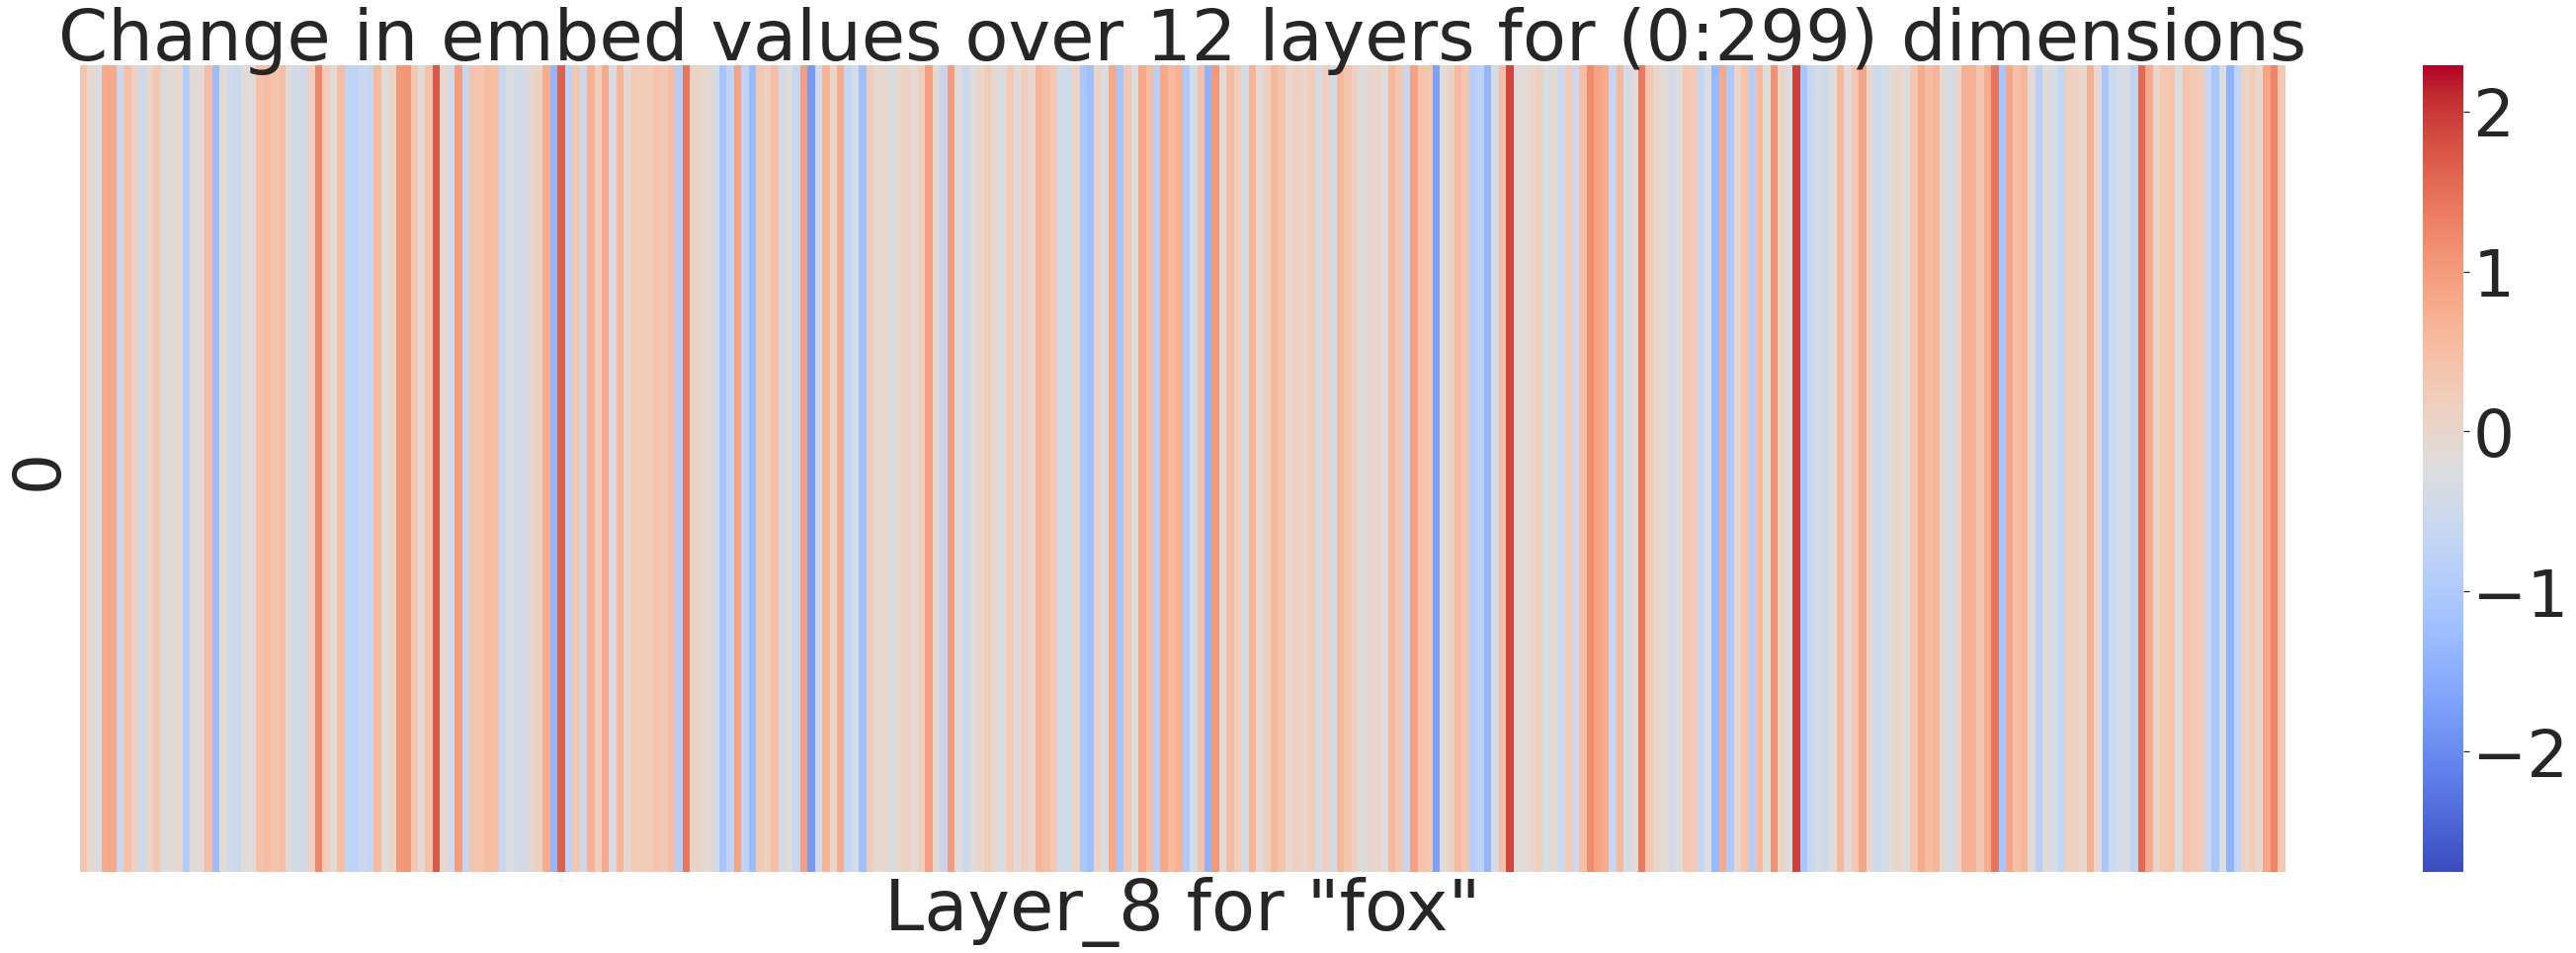

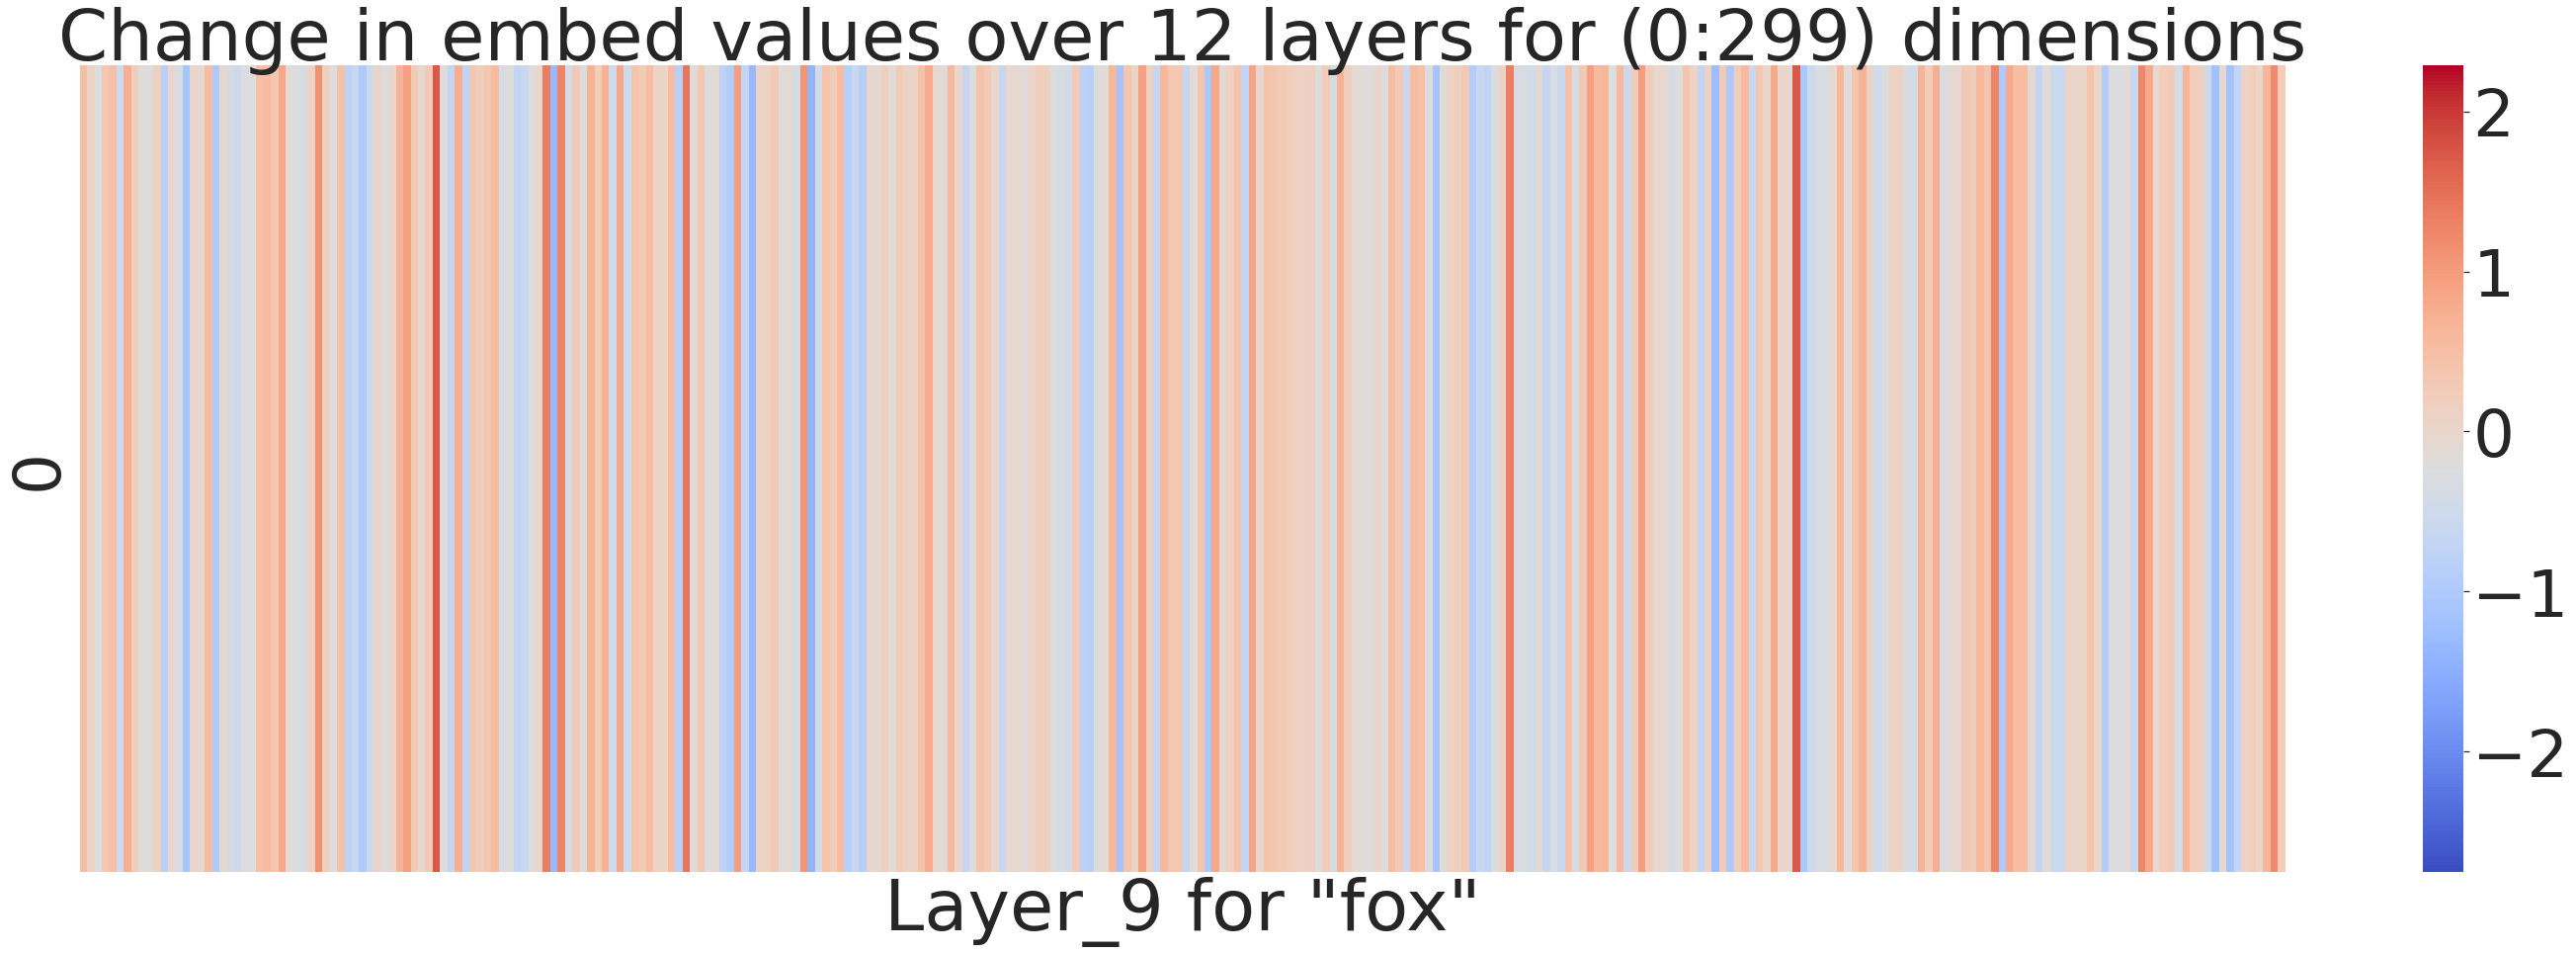

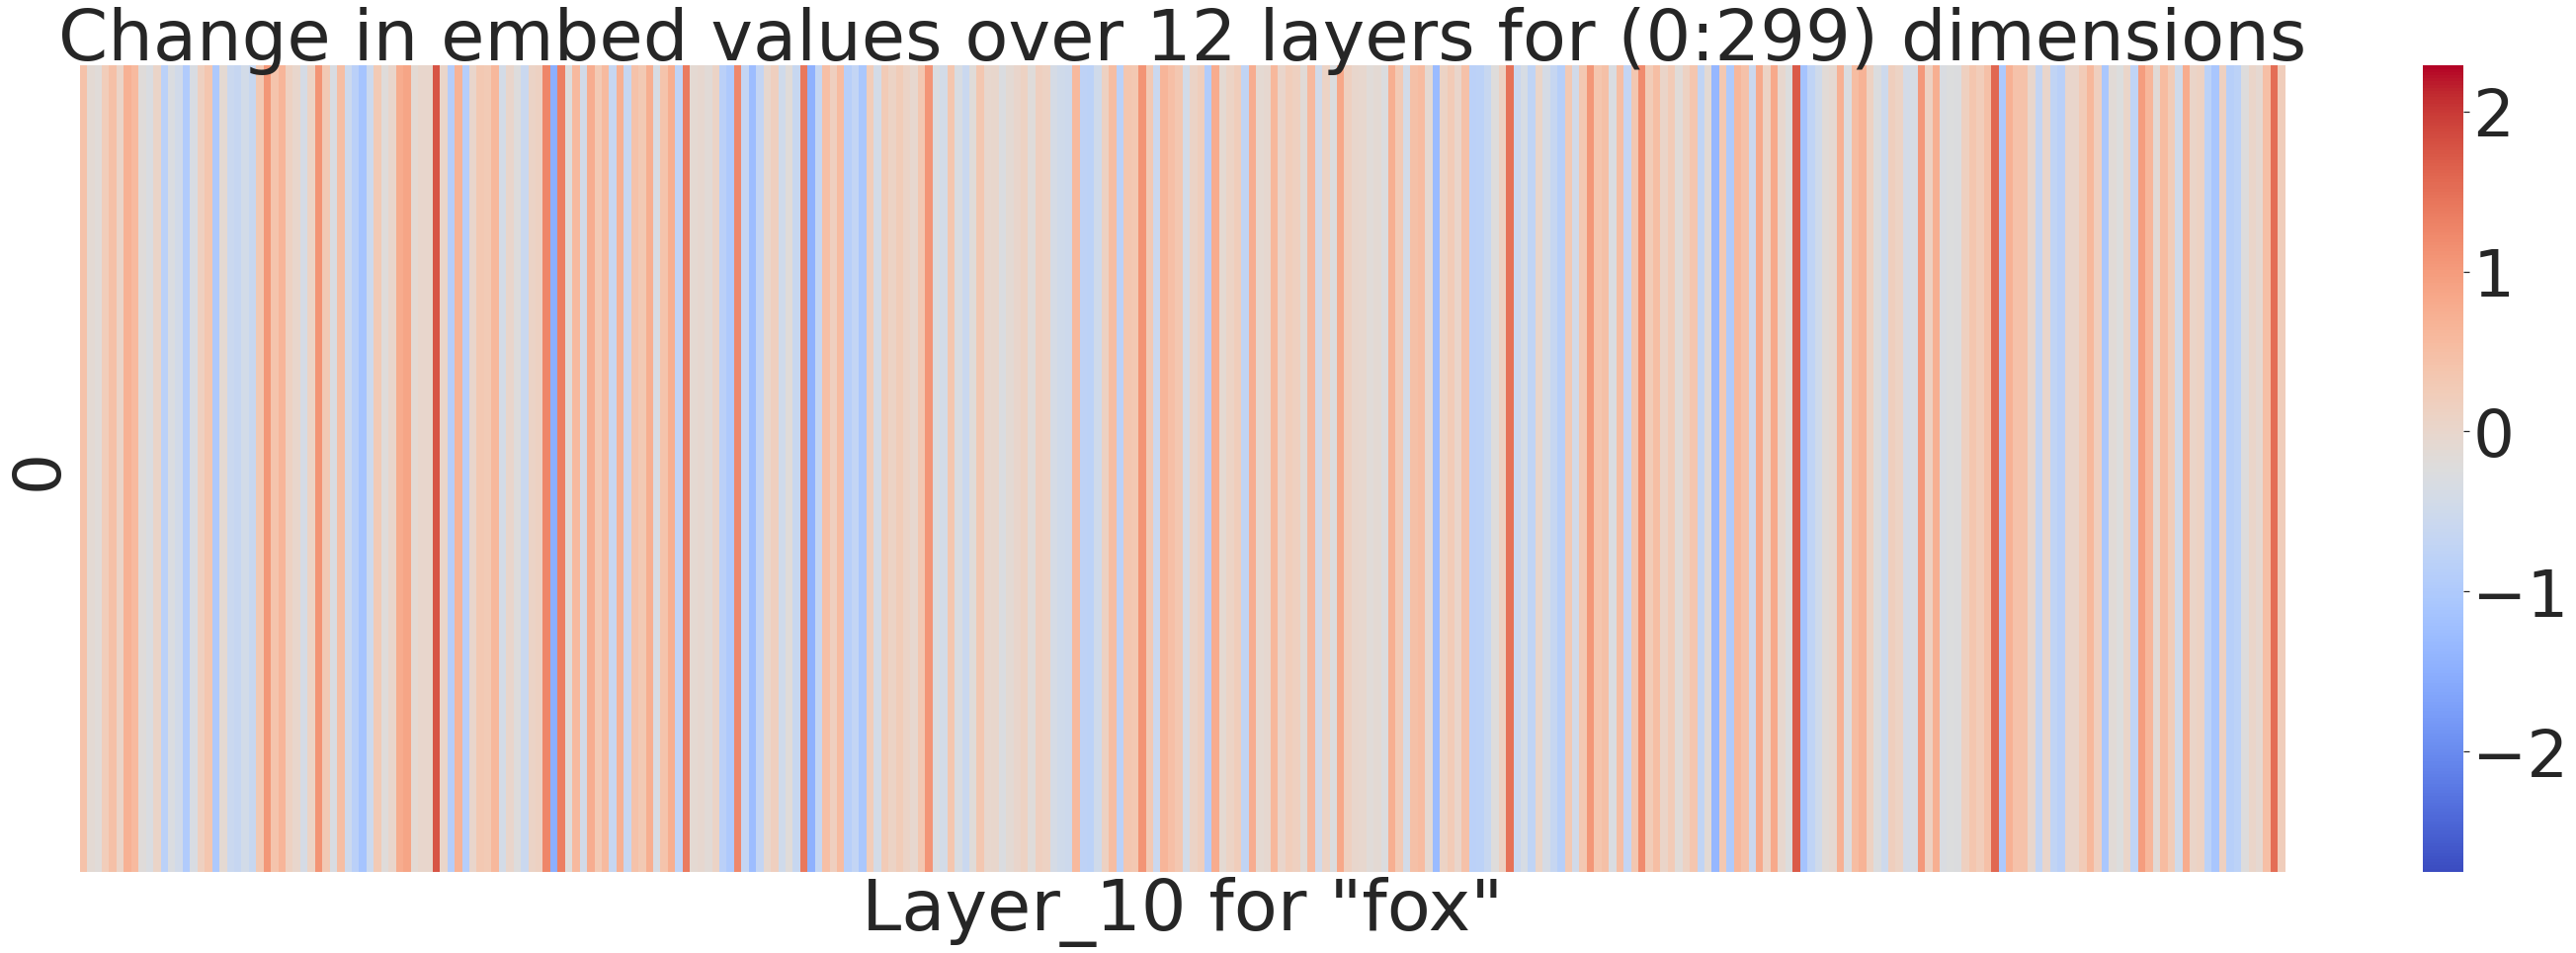

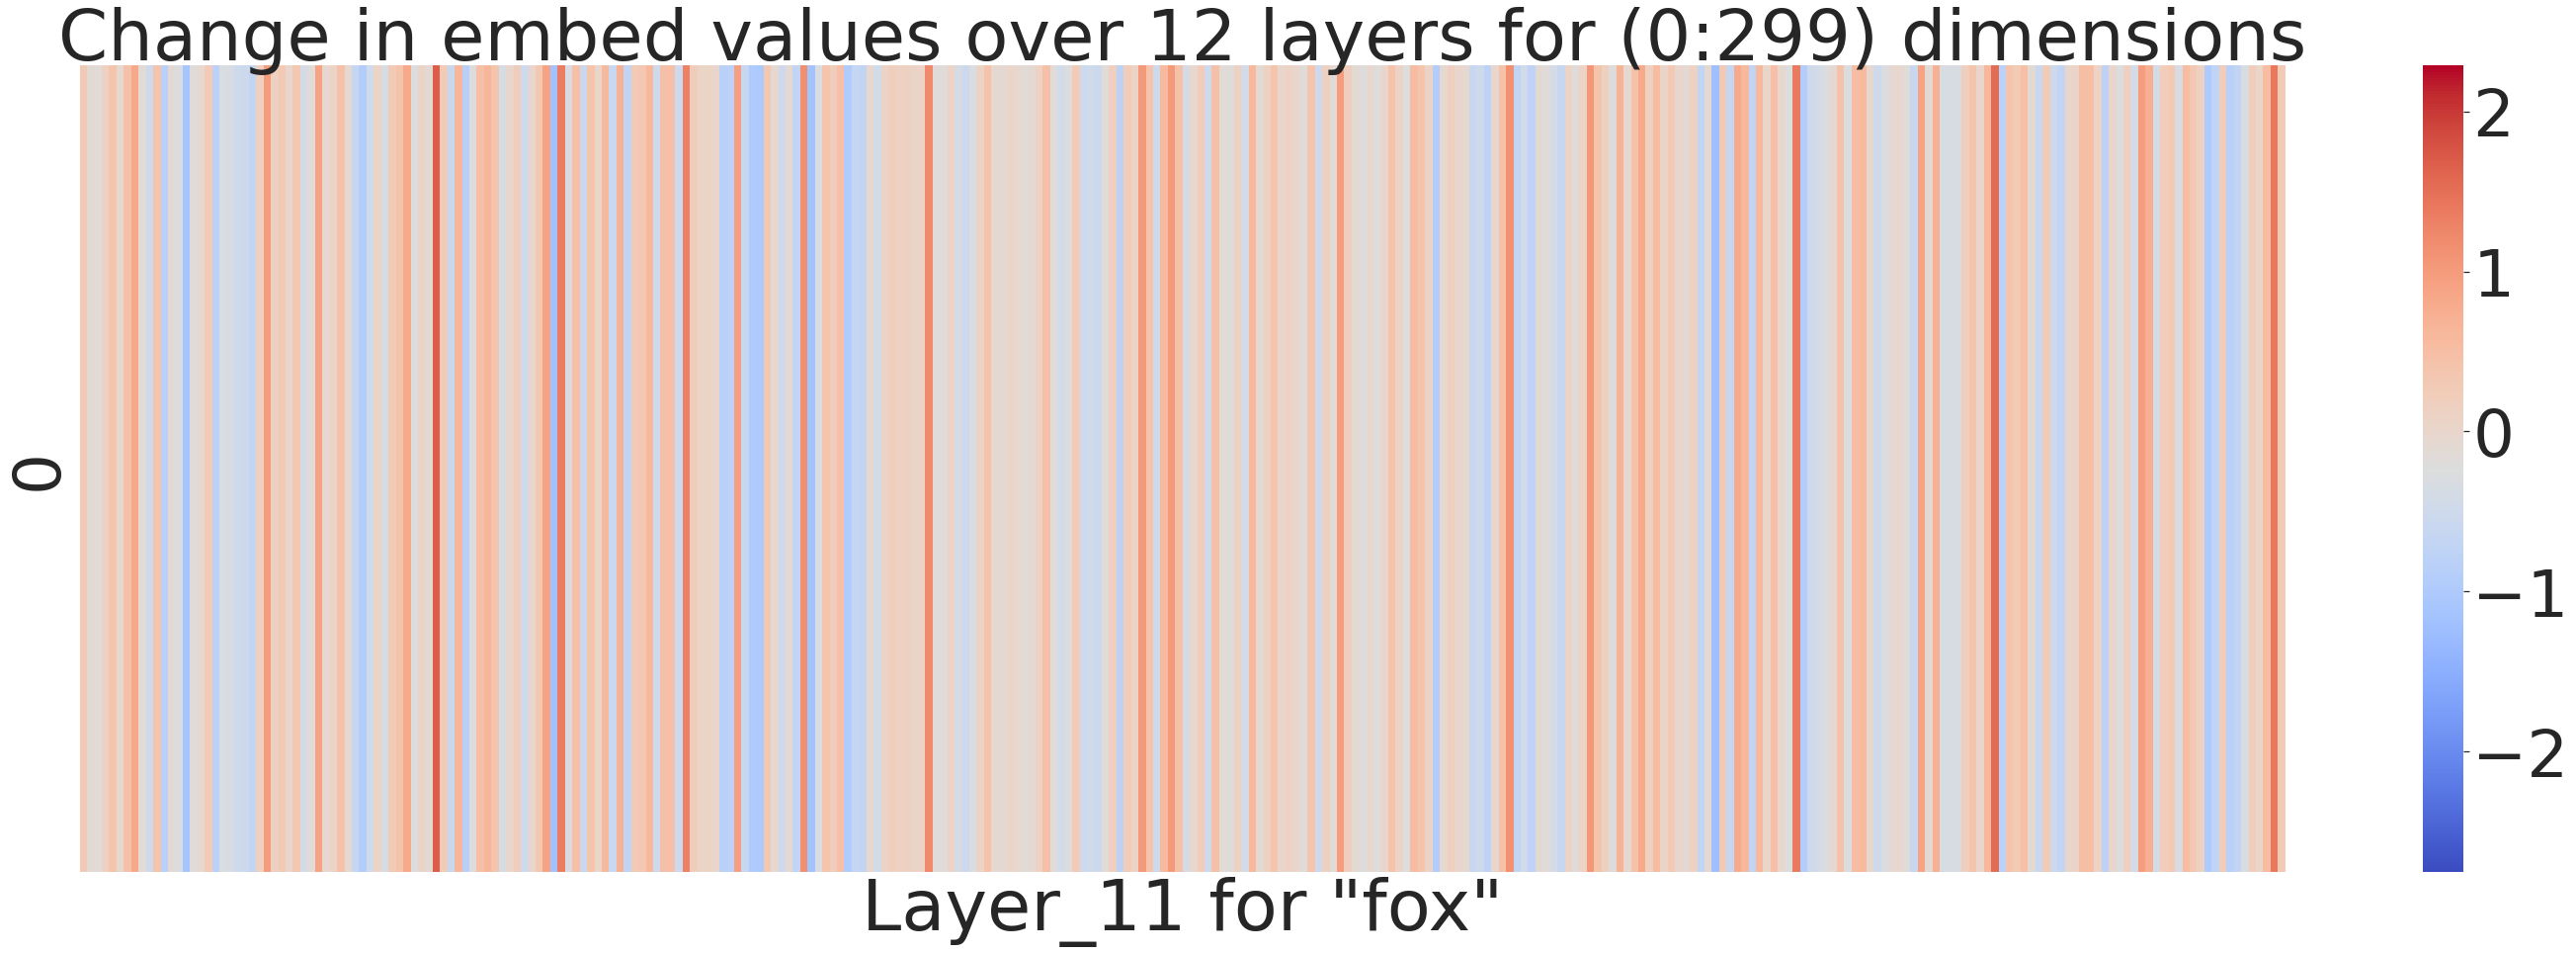

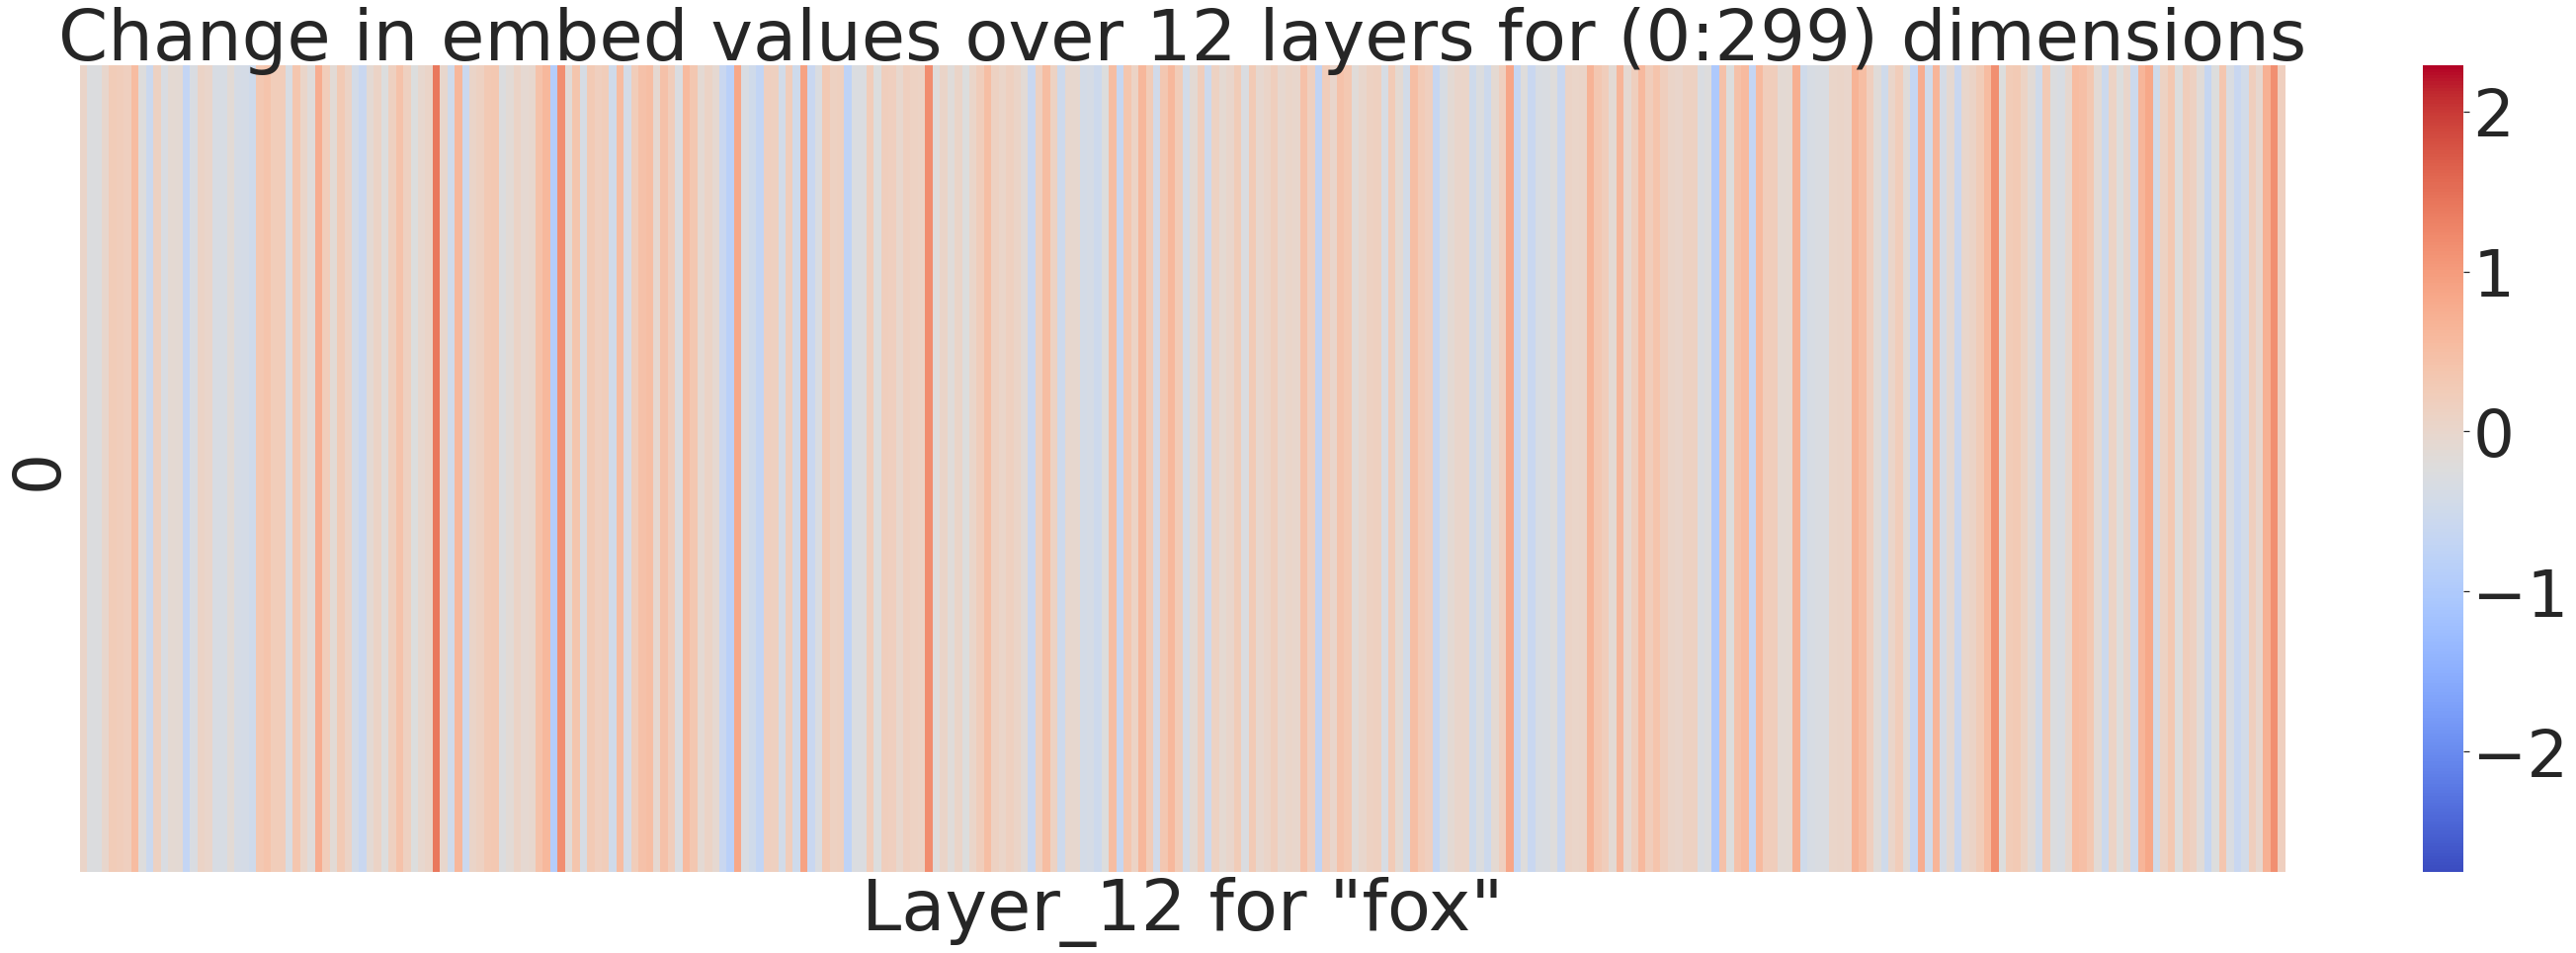

In [21]:
sentence = ["the","quick","brown","fox","jumped","over","the","lazy","dog"]
word_index = 3

output = model(**extract_embeddings.get_tokenized_input(tokenizer,sentence))
output_folder = os.path.join(os.getcwd(), os.path.join("output","layer12viz"))
if not(os.path.exists(output_folder)):
  os.mkdir(output_folder)

all_embeds = [each_layer[0][word_index+1].detach().numpy()[0:300] for each_layer in output["hidden_states"]]
save_filepaths = [os.path.join(output_folder, "Layer_{}.jpg".format(index)) for index in range(0,len(all_embeds))]
layer_display_names = ["Layer_{}".format(index) for index in range(0, len(all_embeds))]
words = [sentence[word_index]]*len(all_embeds)

viz = {
    "embeddings":all_embeds,
    "layer_display_names":layer_display_names,
    "words":words,
    "title":"Change in embed values over 12 layers for (0:299) dimensions",
    "save":True,
    "mode":"separate",
    "save_folder":output_folder
}

graph.plot_embeds(**viz)

In [ ]:
import image

image.create_gif(output_folder)

['Layer_3.jpg', 'Layer_11.jpg', 'Layer_7.jpg', 'Layer_5.jpg', 'Layer_6.jpg', 'Layer_9.jpg', 'Layer_1.jpg', 'Layer_4.jpg', 'Layer_0.jpg', 'Layer_12.jpg', 'Layer_10.jpg', 'Layer_2.jpg', 'Layer_8.jpg']
['Layer_0.jpg', 'Layer_1.jpg', 'Layer_2.jpg', 'Layer_3.jpg', 'Layer_4.jpg', 'Layer_5.jpg', 'Layer_6.jpg', 'Layer_7.jpg', 'Layer_8.jpg', 'Layer_9.jpg', 'Layer_10.jpg', 'Layer_11.jpg', 'Layer_12.jpg']


##References

<h4>
<li>https://jalammar.github.io/illustrated-word2vec/</li>
</h4>